# **Sexismus-Erkennung mit Large Language Models**

# Imports & Setup

In [ ]:
!pip install -r requirements.txt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 27.0 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from datasets import load_dataset, DatasetDict, Dataset, load_from_disk
import matplotlib.pyplot as plt
import tensorflow as tf
import os
from transformers import AutoTokenizer, AutoModel, TFAutoModel
from transformers import AutoModelForSequenceClassification,  AutoConfig
from transformers import Trainer, TrainingArguments, DataCollatorWithPadding, DistilBertModel
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from tqdm import tqdm
import optuna
from collections import Counter
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
import seaborn as sns
import spacy
!python -m spacy download de_core_news_sm
nlp = spacy.load("de_core_news_sm")
import re

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.6/14.6 MB 132.1 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('de_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


## Daten laden

In [ ]:
def get_data():
  ds = load_dataset("ofai/GerMS-AT")
  return ds

get_data()

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

germs-at-train.jsonl: 0.00B [00:00, ?B/s]

germs-at-test.jsonl: 0.00B [00:00, ?B/s]

Generating train split:   0%|          | 0/5998 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1986 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'id', 'annotations', 'round', 'source'],
        num_rows: 5998
    })
    test: Dataset({
        features: ['text', 'id', 'annotations', 'round', 'source'],
        num_rows: 1986
    })
})

# Tokenisierung und Vektorisierung

## Tokenisierung

In [ ]:
def encode_dataset(dataset, batch_size=50):
  model_ckpt = "distilbert-base-german-cased"
  tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

  def tokenize(batch):
      return tokenizer(batch["text"], padding=True, truncation=True)

  # Daten in Datei abspeichern
  data_encoded = dataset.map(tokenize, batched=True, batch_size=batch_size)
  data_encoded.save_to_disk("data_encoded")
  return data_encoded

encode_dataset(get_data())

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/464 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/240k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/479k [00:00<?, ?B/s]

Map:   0%|          | 0/5998 [00:00<?, ? examples/s]

Map:   0%|          | 0/1986 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/5998 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1986 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'id', 'annotations', 'round', 'source', 'input_ids', 'attention_mask'],
        num_rows: 5998
    })
    test: Dataset({
        features: ['text', 'id', 'annotations', 'round', 'source', 'input_ids', 'attention_mask'],
        num_rows: 1986
    })
})

In [ ]:
data_encoded = load_from_disk("data_encoded")

## Extract Hidden States

In [ ]:
def extract_hidden_states(dataset):

  def extraction(batch):

      model_ckpt = "distilbert-base-german-cased"
      tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
      device = "cpu"
      model = AutoModel.from_pretrained(model_ckpt).to(device)

      # Modelleingaben auf der GPU platzieren
      inputs = {k:v.to(device) for k,v in batch.items()
              if k in tokenizer.model_input_names}
      # Hidden States extrahieren
      with torch.no_grad():
        last_hidden_state = model(**inputs).last_hidden_state
      # Vektor zurückgeben
      return {"hidden_state": last_hidden_state[:,0].cpu().numpy()}

  dataset.set_format("torch", columns=["input_ids", "attention_mask", "annotations"])

  data_hidden = dataset.map(extraction, batched=True, batch_size=50, desc="Processing batches")

  # Daten in Datei abspeichern
  data_hidden.save_to_disk("data_hidden_processed")
  return data_hidden

extract_hidden_states(encode_dataset(get_data()))

Map:   0%|          | 0/1986 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/5998 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1986 [00:00<?, ? examples/s]

Processing batches:   0%|          | 0/5998 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/270M [00:00<?, ?B/s]

Processing batches:   0%|          | 0/1986 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/5998 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1986 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'id', 'annotations', 'round', 'source', 'input_ids', 'attention_mask', 'hidden_state'],
        num_rows: 5998
    })
    test: Dataset({
        features: ['text', 'id', 'annotations', 'round', 'source', 'input_ids', 'attention_mask', 'hidden_state'],
        num_rows: 1986
    })
})

In [ ]:
dateipfad = "/content/data_hidden_processed"
hidden_states = load_from_disk(dateipfad)

# Labels extrahieren

### Median der Label-Listen extrahieren (Multi Median Methode)

In [ ]:
def extract_numeric_labels(dataset):
  y_train = dataset["annotations"]

  y_train_numeric = []

  for sample in y_train:
      numeric_labels = [int(ann["label"].split("-")[0]) for ann in sample]  # numerisches Label extrahieren
      mean_label = round(np.mean(numeric_labels))  # Mittelwert berechnen
      y_train_numeric.append(mean_label)

  return np.array(y_train_numeric)

### aufgerundeten Median der Label-Listen extrahieren (Multi Roundup Methode)

In [ ]:
def extract_numeric_labels_roundup(dataset):
  y_train = dataset["annotations"]

  y_train_numeric = []

  for sample in y_train:
      numeric_labels = [int(ann["label"].split("-")[0]) for ann in sample]  # numerisches Label extrahieren
      mean_label = round(np.mean(numeric_labels)+0.5)  # aufgerundeten Mittelwert berechnen
      y_train_numeric.append(mean_label)

  return np.array(y_train_numeric)

### Labels in binäre Klassen 0 und 1 aufteilen

In [ ]:
def extract_numeric_labels_binary(dataset):
  y_train = dataset["annotations"]

  y_train_numeric = []

  for sample in y_train:
      numeric_labels = [int(ann["label"].split("-")[0]) for ann in sample]  # numerisches Label extrahieren
      mean_label = np.mean(numeric_labels)  # Mittelwert berechnen
      if mean_label > 0:
        mean_label = 1 # wenn der Mittelwert größer als 0 ist wird Label 1 gewählt
      else:
        mean_label = 0 # ansonsten Label 0
      y_train_numeric.append(mean_label)

  return np.array(y_train_numeric)

### Labels der individuellen Annotatoren extrahieren

In [ ]:
def extract_numeric_labels_person(dataset):
  # Listen für jeden indivuduellen Annotator erstellen
  a1 = []
  a2 = []
  a3 = []
  a4 = []
  a5 = []
  a7 = []
  a8 = []
  a9 = []
  a10 = []
  a11 = []
  a12 = []
  text_a1 = []
  text_a2 = []
  text_a3 = []
  text_a4 = []
  text_a5 = []
  text_a7 = []
  text_a8 = []
  text_a9 = []
  text_a10 = []
  text_a11 = []
  text_a12 = []
  input_ids_a1 = []
  input_ids_a2 = []
  input_ids_a3 = []
  input_ids_a4 = []
  input_ids_a5 = []
  input_ids_a7 = []
  input_ids_a8 = []
  input_ids_a9 = []
  input_ids_a10 = []
  input_ids_a11 = []
  input_ids_a12 = []
  attention_mask_a1 = []
  attention_mask_a2 = []
  attention_mask_a3 = []
  attention_mask_a4 = []
  attention_mask_a5 = []
  attention_mask_a7 = []
  attention_mask_a8 = []
  attention_mask_a9 = []
  attention_mask_a10 = []
  attention_mask_a11 = []
  attention_mask_a12 = []

  for sample in dataset:
      text = sample["text"]
      annotations = sample["annotations"]  # Liste von dicts mit "user" und "label"
      input_ids = sample['input_ids']
      attention_mask = sample['attention_mask']
      for ann in annotations:
          user = ann["user"]
          label = int(ann["label"].split("-")[0]) # numerisches Label extrahieren
          if user == "A001":
              a1.append(label)
              text_a1.append(text)
              input_ids_a1.append(input_ids)
              attention_mask_a1.append(attention_mask)
          if user == "A002":
              a2.append(label)
              text_a2.append(text)
              input_ids_a2.append(input_ids)
              attention_mask_a2.append(attention_mask)
          if user == "A003":
              a3.append(label)
              text_a3.append(text)
              input_ids_a3.append(input_ids)
              attention_mask_a3.append(attention_mask)
          if user == "A004":
              a4.append(label)
              text_a4.append(text)
              input_ids_a4.append(input_ids)
              attention_mask_a4.append(attention_mask)
          if user == "A005":
              a5.append(label)
              text_a5.append(text)
              input_ids_a5.append(input_ids)
              attention_mask_a5.append(attention_mask)
          if user == "A007":
              a7.append(label)
              text_a7.append(text)
              input_ids_a7.append(input_ids)
              attention_mask_a7.append(attention_mask)
          if user == "A008":
              a8.append(label)
              text_a8.append(text)
              input_ids_a8.append(input_ids)
              attention_mask_a8.append(attention_mask)
          if user == "A009":
              a9.append(label)
              text_a9.append(text)
              input_ids_a9.append(input_ids)
              attention_mask_a9.append(attention_mask)
          if user == "A010":
              a10.append(label)
              text_a10.append(text)
              input_ids_a10.append(input_ids)
              attention_mask_a10.append(attention_mask)
          if user == "A011":
              a11.append(label)
              text_a11.append(text)
              input_ids_a11.append(input_ids)
              attention_mask_a11.append(attention_mask)
          if user == "A012":
              a12.append(label)
              text_a12.append(text)
              input_ids_a12.append(input_ids)
              attention_mask_a12.append(attention_mask)

  return text_a1,a1,input_ids_a1,attention_mask_a1, text_a2,a2,input_ids_a2,attention_mask_a2, text_a3, a3,input_ids_a3,attention_mask_a3, text_a4, a4,input_ids_a4,attention_mask_a4, text_a5,a5,input_ids_a5,attention_mask_a5, text_a7,a7,input_ids_a7,attention_mask_a7, text_a8, a8,input_ids_a8,attention_mask_a8, text_a9,a9,input_ids_a9,attention_mask_a9, text_a10, a10,input_ids_a10,attention_mask_a10, text_a11, a11,input_ids_a11,attention_mask_a11, text_a12, a12,input_ids_a12,attention_mask_a12


### Dictionary mit Daten der individuellen Annotatoren erstellen

In [ ]:
def labels_per_annotator(dataset):

  all_outputs = extract_numeric_labels_person(dataset["train"])
  text_a1, a1, input_ids_a1, attention_mask_a1 = all_outputs[0], all_outputs[1],all_outputs[2], all_outputs[3]
  text_a2, a2, input_ids_a2, attention_mask_a2 = all_outputs[4], all_outputs[5], all_outputs[6], all_outputs[7]
  text_a3, a3, input_ids_a3, attention_mask_a3 = all_outputs[8], all_outputs[9], all_outputs[10], all_outputs[11]
  text_a4, a4, input_ids_a4, attention_mask_a4 = all_outputs[12], all_outputs[13], all_outputs[14], all_outputs[15]
  text_a5, a5, input_ids_a5, attention_mask_a5 = all_outputs[16], all_outputs[17], all_outputs[18], all_outputs[19]
  text_a7, a7, input_ids_a7, attention_mask_a7 = all_outputs[20], all_outputs[21], all_outputs[22], all_outputs[23]
  text_a8, a8, input_ids_a8, attention_mask_a8 = all_outputs[24], all_outputs[25], all_outputs[26], all_outputs[27]
  text_a9, a9, input_ids_a9, attention_mask_a9 = all_outputs[28], all_outputs[29], all_outputs[30], all_outputs[31]
  text_a10, a10, input_ids_a10, attention_mask_a10 = all_outputs[32], all_outputs[33], all_outputs[34], all_outputs[35]
  text_a11, a11, input_ids_a11, attention_mask_a11 = all_outputs[36], all_outputs[37], all_outputs[38], all_outputs[39]
  text_a12, a12, input_ids_a12, attention_mask_a12 = all_outputs[40], all_outputs[41], all_outputs[42], all_outputs[43]

  all_outputs_test = extract_numeric_labels_person(dataset["test"])
  text_a1_test, a1_test, input_ids_a1_test, attention_mask_a1_test = all_outputs_test[0], all_outputs_test[1], all_outputs_test[2], all_outputs_test[3]
  text_a2_test, a2_test, input_ids_a2_test, attention_mask_a2_test = all_outputs_test[4], all_outputs_test[5], all_outputs_test[6], all_outputs_test[7]
  text_a3_test, a3_test, input_ids_a3_test, attention_mask_a3_test = all_outputs_test[8], all_outputs_test[9], all_outputs_test[10], all_outputs_test[11]
  text_a4_test, a4_test, input_ids_a4_test, attention_mask_a4_test = all_outputs_test[12], all_outputs_test[13], all_outputs_test[14], all_outputs_test[15]
  text_a5_test, a5_test, input_ids_a5_test, attention_mask_a5_test = all_outputs_test[16], all_outputs_test[17], all_outputs_test[18], all_outputs_test[19]
  text_a7_test, a7_test, input_ids_a7_test, attention_mask_a7_test = all_outputs_test[20], all_outputs_test[21], all_outputs_test[22], all_outputs_test[23]
  text_a8_test, a8_test, input_ids_a8_test, attention_mask_a8_test = all_outputs_test[24], all_outputs_test[25], all_outputs_test[26], all_outputs_test[27]
  text_a9_test, a9_test, input_ids_a9_test, attention_mask_a9_test = all_outputs_test[28], all_outputs_test[29], all_outputs_test[30], all_outputs_test[31]
  text_a10_test, a10_test, input_ids_a10_test, attention_mask_a10_test = all_outputs_test[32], all_outputs_test[33], all_outputs_test[34], all_outputs_test[35]
  text_a11_test, a11_test, input_ids_a11_test, attention_mask_a11_test = all_outputs_test[36], all_outputs_test[37], all_outputs_test[38], all_outputs_test[39]
  text_a12_test, a12_test, input_ids_a12_test, attention_mask_a12_test = all_outputs_test[40], all_outputs_test[41], all_outputs_test[42], all_outputs_test[43]

  texts = {
      "a1": text_a1,
      "a2": text_a2,
      "a3": text_a3,
      "a4": text_a4,
      "a5": text_a5,
      "a7": text_a7,
      "a8": text_a8,
      "a9": text_a9,
      "a10": text_a10,
      "a11": text_a11,
      "a12": text_a12}

  labels = {
      "a1": a1,
      "a2": a2,
      "a3": a3,
      "a4": a4,
      "a5": a5,
      "a7": a7,
      "a8": a8,
      "a9": a9,
      "a10": a10,
      "a11": a11,
      "a12": a12}

  input_ids = {
      "a1": input_ids_a1,
      "a2": input_ids_a2,
      "a3": input_ids_a3,
      "a4": input_ids_a4,
      "a5": input_ids_a5,
      "a7": input_ids_a7,
      "a8": input_ids_a8,
      "a9": input_ids_a9,
      "a10": input_ids_a10,
      "a11": input_ids_a11,
      "a12": input_ids_a12}

  attention_mask = {
      "a1": attention_mask_a1,
      "a2": attention_mask_a2,
      "a3": attention_mask_a3,
      "a4": attention_mask_a4,
      "a5": attention_mask_a5,
      "a7": attention_mask_a7,
      "a8": attention_mask_a8,
      "a9": attention_mask_a9,
      "a10": attention_mask_a10,
      "a11": attention_mask_a11,
      "a12": attention_mask_a12}

  texts_test = {
      "a1": text_a1_test,
      "a2": text_a2_test,
      "a3": text_a3_test,
      "a4": text_a4_test,
      "a5": text_a5_test,
      "a7": text_a7_test,
      "a8": text_a8_test,
      "a9": text_a9_test,
      "a10": text_a10_test,
      "a11": text_a11_test,
      "a12": text_a12_test}

  labels_test = {
      "a1": a1_test,
      "a2": a2_test,
      "a3": a3_test,
      "a4": a4_test,
      "a5": a5_test,
      "a7": a7_test,
      "a8": a8_test,
      "a9": a9_test,
      "a10": a10_test,
      "a11": a11_test,
      "a12": a12_test}

  input_ids_test = {
      "a1": input_ids_a1_test,
      "a2": input_ids_a2_test,
      "a3": input_ids_a3_test,
      "a4": input_ids_a4_test,
      "a5": input_ids_a5_test,
      "a7": input_ids_a7_test,
      "a8": input_ids_a8_test,
      "a9": input_ids_a9_test,
      "a10": input_ids_a10_test,
      "a11": input_ids_a11_test,
      "a12": input_ids_a12_test}

  attention_mask_test = {
      "a1": attention_mask_a1_test,
      "a2": attention_mask_a2_test,
      "a3": attention_mask_a3_test,
      "a4": attention_mask_a4_test,
      "a5": attention_mask_a5_test,
      "a7": attention_mask_a7_test,
      "a8": attention_mask_a8_test,
      "a9": attention_mask_a9_test,
      "a10": attention_mask_a10_test,
      "a11": attention_mask_a11_test,
      "a12": attention_mask_a12_test}



  # DatasetDict erstellen
  datasets_per_annotator = {}

  for key in texts:
      datasets_per_annotator[key] = DatasetDict({
          "train": Dataset.from_dict({
              "text": texts[key],
              "labels": labels[key],
              "input_ids": input_ids[key],
              "attention_mask": attention_mask[key]
          }),
          "test": Dataset.from_dict({
              "text": texts_test[key],
              "labels": labels_test[key],
              "input_ids": input_ids_test[key],
              "attention_mask": attention_mask_test[key]
          })
      })

  # Daten in Datei abspeichern
  for name, ds_dict in datasets_per_annotator.items():
    ds_dict.save_to_disk(f"datasets_per_annotator/{name}")

  return datasets_per_annotator

labels_per_annotator(data_encoded)

Saving the dataset (0/1 shards):   0%|          | 0/970 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/328 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/5998 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1986 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1242 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/456 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1394 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/504 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1552 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/542 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1246 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/451 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1849 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/649 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/2923 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/971 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/5998 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1986 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/927 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/114 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/5998 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1661 [00:00<?, ? examples/s]

{'a1': DatasetDict({
     train: Dataset({
         features: ['text', 'labels', 'input_ids', 'attention_mask'],
         num_rows: 970
     })
     test: Dataset({
         features: ['text', 'labels', 'input_ids', 'attention_mask'],
         num_rows: 328
     })
 }),
 'a2': DatasetDict({
     train: Dataset({
         features: ['text', 'labels', 'input_ids', 'attention_mask'],
         num_rows: 5998
     })
     test: Dataset({
         features: ['text', 'labels', 'input_ids', 'attention_mask'],
         num_rows: 1986
     })
 }),
 'a3': DatasetDict({
     train: Dataset({
         features: ['text', 'labels', 'input_ids', 'attention_mask'],
         num_rows: 1242
     })
     test: Dataset({
         features: ['text', 'labels', 'input_ids', 'attention_mask'],
         num_rows: 456
     })
 }),
 'a4': DatasetDict({
     train: Dataset({
         features: ['text', 'labels', 'input_ids', 'attention_mask'],
         num_rows: 1394
     })
     test: Dataset({
         features:

In [ ]:
annotator_names = ["a1", "a2", "a3", "a4", "a5", "a7", "a8", "a9", "a10", "a11", "a12"]

datasets_per_annotator = {
    name: load_from_disk(f"datasets_per_annotator/{name}") for name in annotator_names}

### Annotator Labels visualisieren

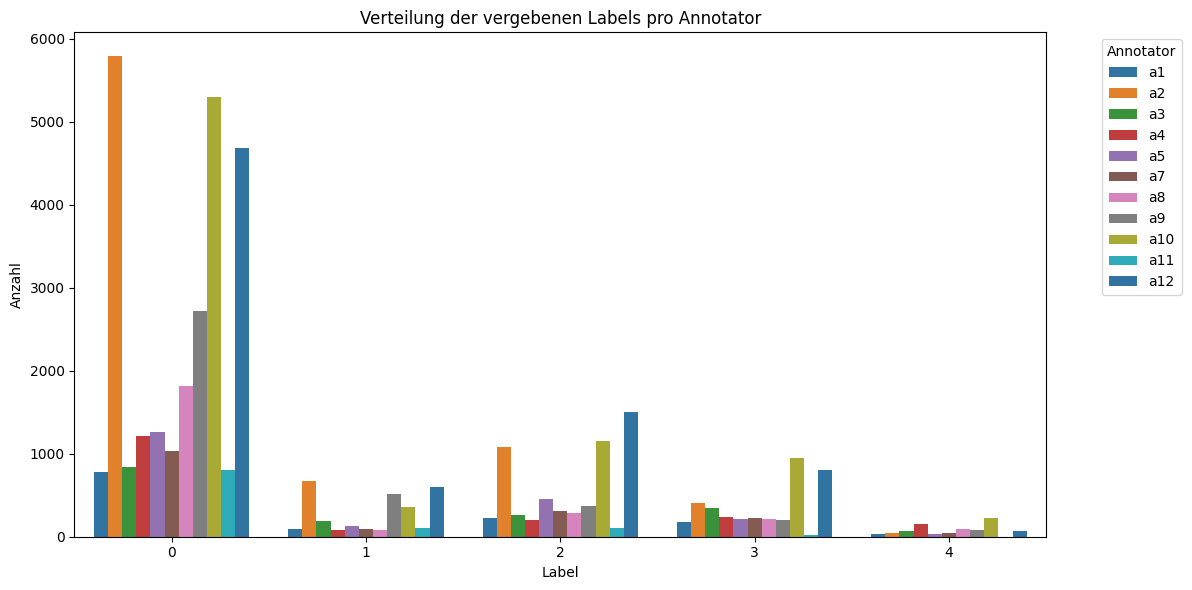

In [ ]:
all_data = []

for annotator, ds in datasets_per_annotator.items():
    for split in ["train", "test"]:
        if split in ds:
            labels = ds[split]["labels"]
            for label in labels:
                all_data.append({"Annotator": annotator, "Label": label, "Split": split})

df = pd.DataFrame(all_data)

# Plot erstellen
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x="Label", hue="Annotator", palette="tab10")
plt.title("Verteilung der vergebenen Labels pro Annotator")
plt.xlabel("Label")
plt.ylabel("Anzahl")
plt.legend(title="Annotator", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

## Labels zu Dataset hinzufügen

In [ ]:
def add_labels(dataset):
  # Multi Median Labels zum Dataset hinzufügen
  dataset["train"] = dataset["train"].add_column("labels", extract_numeric_labels(dataset["train"]))
  dataset["test"] = dataset["test"].add_column("labels", extract_numeric_labels(dataset["test"]))

  # Multi Roundup Labels zum Dataset hinzufügen
  dataset["train"] = dataset["train"].add_column("labels_roundup", extract_numeric_labels_roundup(dataset["train"]))
  dataset["test"] = dataset["test"].add_column("labels_roundup", extract_numeric_labels_roundup(dataset["test"]))

  # Binäre Labels zum Dataset hinzufügen
  dataset["train"] = dataset["train"].add_column("labels_binary", extract_numeric_labels_binary(dataset["train"]))
  dataset["test"] = dataset["test"].add_column("labels_binary", extract_numeric_labels_binary(dataset["test"]))

  return dataset

add_labels(hidden_states)

DatasetDict({
    train: Dataset({
        features: ['text', 'id', 'annotations', 'round', 'source', 'input_ids', 'attention_mask', 'hidden_state', 'labels', 'labels_roundup', 'labels_binary'],
        num_rows: 5998
    })
    test: Dataset({
        features: ['text', 'id', 'annotations', 'round', 'source', 'input_ids', 'attention_mask', 'hidden_state', 'labels', 'labels_roundup', 'labels_binary'],
        num_rows: 1986
    })
})

### überflüssige Spalten des Datasets löschen

In [ ]:
dataset_binary = hidden_states.remove_columns(["id", "annotations", "round", "source", "labels", "labels_roundup"])
dataset_binary = dataset_binary.rename_column("labels_binary", "labels")

dataset_multi = hidden_states.remove_columns(["id", "annotations", "round", "source", "labels_binary", "labels_roundup"])

dataset_multi_roundup = hidden_states.remove_columns(["id", "annotations", "round", "source", "labels_binary", "labels"])
dataset_multi_roundup = dataset_multi_roundup.rename_column("labels_roundup", "labels")

print(dataset_multi.column_names)
print(dataset_multi_roundup.column_names)
print(dataset_binary.column_names)

{'train': ['text', 'input_ids', 'attention_mask', 'hidden_state', 'labels'], 'test': ['text', 'input_ids', 'attention_mask', 'hidden_state', 'labels']}
{'train': ['text', 'input_ids', 'attention_mask', 'hidden_state', 'labels'], 'test': ['text', 'input_ids', 'attention_mask', 'hidden_state', 'labels']}
{'train': ['text', 'input_ids', 'attention_mask', 'hidden_state', 'labels'], 'test': ['text', 'input_ids', 'attention_mask', 'hidden_state', 'labels']}


# linguistische Analyse der sexistisch gelabelten Kommentare

### Alle Kommentare mit Label 4 extrahieren

In [ ]:
dataset_binary.reset_format()
dataset_multi.reset_format()
dataset_multi_roundup.reset_format()

In [ ]:
# Alle Kommentare mit Label 4 aus beiden Splits holen (Multi Median)
texts_train = [sample["text"] for sample in dataset_multi["train"] if sample["labels"] == 4]
texts_test = [sample["text"] for sample in dataset_multi["test"] if sample["labels"] == 4]
all_texts = texts_train + texts_test
print("Anzahl Kommentare mit Label 4: ", len(all_texts))

# Daten in Datei abspeichern
with open("label_4.txt", "w", encoding="utf-8") as f:
    for text in all_texts:
        f.write(text.strip() + "\n")

Anzahl Kommentare mit Label 4:  33


In [ ]:
# Alle Kommentare mit Label 4 aus beiden Splits holen (Multi Roundup)
texts_train = [sample["text"] for sample in dataset_multi_roundup["train"] if sample["labels"] == 4]
texts_test = [sample["text"] for sample in dataset_multi_roundup["test"] if sample["labels"] == 4]
all_texts = texts_train + texts_test
print("Anzahl Kommentare mit Label 4: ", len(all_texts))

# Daten in Datei abspeichern
with open("label_4_roundup.txt", "w", encoding="utf-8") as f:
    for text in all_texts:
        f.write(text.strip() + "\n")

Anzahl Kommentare mit Label 4:  274


### Die häufigsten Worte aus den Label 4 Kommentaren herausfiltern

In [ ]:
with open("label_4_roundup.txt", "r", encoding="utf-8") as file:
    content = file.read()

text = re.sub(r"[^a-zA-Z0-9\s]", "", content).lower()
words = text.split()

# Wörter zählen
wordcount = Counter(words)

# Top-Wörter ausgeben
print("Häufigste Wörter:")
for word, count in wordcount.most_common(10): # Top 10
  print(f"{word}: {count}")
print("\n")

doc = nlp(content)

# Nomen extrahieren
nouns = [token.lemma_ for token in doc if token.pos_ in ("NOUN")]

# Adjektive extrahieren
adj = [token.lemma_ for token in doc if token.pos_ in ("ADJ")]

# Adverben extrahieren
adv = [token.lemma_ for token in doc if token.pos_ in ("ADV")]

# Verben extrahieren
verb = [token.lemma_ for token in doc if token.pos_ in ("VERB")]

nounlist = []
nouncount = Counter(nouns)
print("Häufigste Nomen:")
for noun, count in nouncount.most_common(30): # Top 30
  print(f"{noun}: {count}")
  nounlist.append(noun)
print("\n")

adjlist = []
adjcount = Counter(adj)
print("Häufigste Adjektive:")
for adj, count in adjcount.most_common(30): # Top 30
  print(f"{adj}: {count}")
  adjlist.append(adj)
print("\n")

advcount = Counter(adv)
print("Häufigste Adverben:")
for adv, count in advcount.most_common(5): # Top 5
  print(f"{adv}: {count}")
print("\n")

verbcount = Counter(verb)
print("Häufigste Verben:")
for verb, count in verbcount.most_common(5): # Top 5
  print(f"{verb}: {count}")
print("\n")

with open("nounlist.txt", "w", encoding="utf-8") as f:
    for word in nounlist:
        f.write(word.strip() + "\n")

with open("adjlist.txt", "w", encoding="utf-8") as f:
    for word in adjlist:
        f.write(word.strip() + "\n")

Häufigste Wörter:
die: 266
und: 183
sie: 172
der: 137
nicht: 128
das: 116
ist: 113
ich: 101
in: 94
es: 93


Häufigste Nomen:
Frau: 154
Mann: 72
Kind: 17
Jahr: 16
Dame: 13
Geld: 10
Weiber: 9
Leben: 9
Haus: 7
Zeit: 7
Bein: 7
Opfer: 7
Mund: 6
Job: 6
Geschichte: 6
Bett: 6
Sex: 6
Quote: 6
Verantwortung: 6
Karriere: 5
Tag: 5
Kunst: 5
Foto: 5
Küche: 4
Vorteil: 4
Fall: 4
Sache: 4
Vergewaltigung: 4
Politik: 4
Oide: 4


Häufigste Adjektive:
gut: 16
eigen: 10
anderer: 8
letzter: 8
alt: 7
groß: 6
hübsch: 6
sexuell: 6
klein: 6
weiblich: 5
hoch: 5
hässlich: 4
erster: 4
echt: 4
richtig: 4
einzig: 3
nächster: 3
ganz: 3
jung: 3
fett: 3
fesch: 3
dumm: 2
niedrig: 2
geil: 2
politisch: 2
neu: 2
wichtig: 2
feministisch: 2
hübscher: 2
wund: 2


Häufigste Adverben:
auch: 71
so: 68
nur: 53
dann: 41
noch: 38


Häufigste Verben:
machen: 38
haben: 30
geben: 23
tun: 19
kommen: 19




# Wortliste mit frauenfeindlichen Begriffen generieren

Wortliste von ChatGPT

In [ ]:
# Dateipfad muss gegebenenfalls angepasst werden, je nachdem wo die Dateie abgespeichert ist.
# Sie kann im GitHub Ordner heruntergeladen werden.
path = '/content/wordlist_chatgpt.txt'
with open(path, "r", encoding="utf-8") as f:
  wordlist_gpt = [zeile.strip() for zeile in f]

Wortliste von Google Gemini


In [ ]:
# Dateipfad muss gegebenenfalls angepasst werden, je nachdem wo die Dateie abgespeichert ist.
# Sie kann im GitHub Ordner heruntergeladen werden.
path = '/content/wordlist_gemini.txt'
with open(path, "r", encoding="utf-8") as f:
   lines = f.readlines()
wordlist_gemini = list(dict.fromkeys([line.strip() for line in lines if line.strip()]))


Wortliste von Grok

In [ ]:
# Dateipfad muss gegebenenfalls angepasst werden, je nachdem wo die Dateie abgespeichert ist.
# Sie kann im GitHub Ordner heruntergeladen werden.
path = '/content/wordlist_grok.txt'
with open(path, "r", encoding="utf-8") as f:
   lines = f.readlines()
wordlist_grok = list(dict.fromkeys([line.strip() for line in lines if line.strip()]))

In [ ]:
# Listen zusammenführen und Duplikate entfernen
wordlist_complete = list(set(wordlist_gpt + wordlist_gemini + wordlist_grok))
print(wordlist_complete)
print("Länge der zusammengefügten Wortliste: ", len(wordlist_complete))

['objekt', 'dramaqueen', 'typisch blond', 'zänkisch', 'launisch', 'irrational', 'unterwürfig', 'frauen können kein auto fahren', 'hässlich', 'flachlegen', 'graue maus', 'kann keine technik', 'barbie', 'tratschtante', 'dummes huhn', 'kann keine entscheidungen treffen', 'nutzlos', 'hure', 'typisch frau', 'friseurtussi', 'tussi', 'nutte', 'hat ihre tage', 'keine ahnung von politik', 'plage', 'unterwürfigkeit steht ihr', 'sexobjekt', 'küchenmagd', 'nur am meckern', 'fette nutte', 'emotional instabil', 'nicht teamfähig', 'gold digger', 'weiberkram', 'zieht sich aufreizend an', 'schlammsau', 'begriffsstutzig', 'weint sofort', 'du gehörst verprügelt', 'frauen und technik', 'vergewaltiger', 'lächerlich', 'spermaschlampe', 'zuviel gefühle', 'opfer', 'naiv', 'keine führungsqualitäten', 'wollte es doch', 'beleidigte leberwurst', 'kein rückgrat', 'sollte man mal richtig...', 'unfähig zur führung', 'ficken', 'schwach', 'mädel', 'kann nichts alleine', 'zeigen, wer der chef ist', 'tippse', 'leicht zu

Ermitteln der Häufigkeit, mit der die Begriffe aus der Wortliste in den Kommentaren vorkommen, sortiert nach vergebenem Label

In [ ]:
def contains_sexist_word(dataset, sexist_words):
  # Begriffe, die hauptsächlich in als nicht sexistisch gelabelten Kommentaren auftreten entfernen
  delete = ['dumm', 'heiß','nörgelnd', 'ausgedient', 'begriffsstutzig', 'frigid', 'gehört an den herd', 'nur eine frau', 'biest', 'jagen', 'püppchen', 'tippse', 'wertlos', 'heulsuse', 'nutzlos', 'spielzeug', 'vitamin b', 'zähmen', 'plage', 'beleidigte leberwurst']
  sexist_words_filtered = [word for word in sexist_words if word not in delete]
  print(sexist_words_filtered)

  count = 0
  label_0_words = []
  label_1_words = []
  label_2_words = []
  label_3_words = []
  label_4_words = []

  label_0 = 0
  label_1 = 0
  label_2 = 0
  label_3 = 0
  label_4 = 0

  for sample in dataset:
    text = sample["text"]
    label = sample["labels"]
    text = text.lower()
    for word in sexist_words_filtered:
      if word in text:
        count += 1
        if label == 0:
          label_0 += 1
          label_0_words.append(word)
        if label == 1:
          label_1 += 1
          label_1_words.append(word)
        if label == 2:
          label_2 += 1
          label_2_words.append(word)
        if label == 3:
          label_3 += 1
          label_3_words.append(word)
        if label == 4:
          label_4 += 1
          label_4_words.append(word)

  print("COUNT = ", count)
  print("LABEL 0 Count = ", label_0)
  print("LABEL 1 Count = ", label_1)
  print("LABEL 2 Count = ", label_2)
  print("LABEL 3 Count = ", label_3)
  print("LABEL 4 Count = ", label_4, "\n")
  false0 = Counter(label_0_words)
  print("häufigste Label 0 Worte:", false0)
  false1 = Counter(label_1_words)
  print("häufigste Label 1 Worte:", false1)
  false2 = Counter(label_2_words)
  print("häufigste Label 2 Worte:", false2)
  false3 = Counter(label_3_words)
  print("häufigste Label 3 Worte:", false3)
  false4 = Counter(label_4_words)
  print("häufigste Label 4 Worte:", false4, "\n")

  # alle Listen in Mengen umwandeln
  set1 = set(false0)
  set2 = set(false0 + false1)
  set_rest = set(false1 + false2 + false3 + false4)
  set_high = set(false2 + false3 + false4)

  # Wörter, die nur in liste1 vorkommen identifizieren
  only_in_list1 = set1 - set_rest

  # Wörter, die nur in liste1 und liste2 vorkommen identifizieren
  only_in_list1_2 = set2 - set_high

  print("nur in der Label 0 Liste: ", only_in_list1, "Länge: " , len(only_in_list1))
  print("nur in der Label 0 und 1 Liste: ", only_in_list1_2, "Länge: " , len(only_in_list1_2))
  print("Länge der delete-Liste: ", len(delete))
  print("Länge der gefilterten Wortliste: ", len(sexist_words_filtered))


  counter = Counter({
    'label0': label_0,
    'label1': label_1,
    'label2': label_2,
    'label3': label_3,
    'label4': label_4})

  # Einzelwerte
  klasse1_count = counter['label0']
  rest_count = sum(counter[k] for k in ['label1', 'label2', 'label3', 'label4'])
  gesamt = klasse1_count + rest_count


  # Prozentwerte berechnen
  prozent_klasse1 = (klasse1_count / gesamt) * 100 if gesamt > 0 else 0
  prozent_rest = (rest_count / gesamt) * 100 if gesamt > 0 else 0

  # Ausgabe
  print(f"Label 0: {prozent_klasse1:.2f}%")
  print(f"Label 1–5: {prozent_rest:.2f}%")

  with open("sexist_words_filtered.txt", "w", encoding="utf-8") as f:
    for word in sexist_words_filtered:
        f.write(word.strip() + "\n")

contains_sexist_word(dataset_multi_roundup["train"], wordlist_complete)

['objekt', 'dramaqueen', 'typisch blond', 'zänkisch', 'launisch', 'irrational', 'unterwürfig', 'frauen können kein auto fahren', 'hässlich', 'flachlegen', 'graue maus', 'kann keine technik', 'barbie', 'tratschtante', 'dummes huhn', 'kann keine entscheidungen treffen', 'hure', 'typisch frau', 'friseurtussi', 'tussi', 'nutte', 'hat ihre tage', 'keine ahnung von politik', 'unterwürfigkeit steht ihr', 'sexobjekt', 'küchenmagd', 'nur am meckern', 'fette nutte', 'emotional instabil', 'nicht teamfähig', 'gold digger', 'weiberkram', 'zieht sich aufreizend an', 'schlammsau', 'weint sofort', 'du gehörst verprügelt', 'frauen und technik', 'vergewaltiger', 'lächerlich', 'spermaschlampe', 'zuviel gefühle', 'opfer', 'naiv', 'keine führungsqualitäten', 'wollte es doch', 'kein rückgrat', 'sollte man mal richtig...', 'unfähig zur führung', 'ficken', 'schwach', 'mädel', 'kann nichts alleine', 'zeigen, wer der chef ist', 'leicht zu beeinflussen', 'nicht fähig zu denken', 'nicht durchsetzungsfähig', 'hexe

In [ ]:
# verbesserte Wortliste in Datei abspeichern
with open("sexist_words_filtered.txt", "r", encoding="utf-8") as file:
    sexist_words_filtered = file.read()
    sexist_words_filtered = list(sexist_words_filtered.split("\n"))
    sexist_words_filtered = [word for word in sexist_words_filtered if word.strip() != '']

## Neue Datasets mit "has_sexist_word" Feature erstellen

In [ ]:
dataset_binary_newfeature = dataset_binary
dataset_multi_newfeature = dataset_multi
dataset_multi_roundup_newfeature = dataset_multi_roundup

In [ ]:
def sexist_word(text, sexist_words):
    return int(any(word in text.lower() for word in sexist_words))

print(len(dataset_binary["train"]))
print(len(dataset_binary["test"]))

dataset_binary_newfeature["train"] = dataset_binary_newfeature["train"].map(lambda x: {"has_sexist_word": sexist_word(x["text"], sexist_words_filtered)})
dataset_binary_newfeature["test"] = dataset_binary_newfeature["test"].map(lambda x: {"has_sexist_word": sexist_word(x["text"], sexist_words_filtered)})

dataset_multi_newfeature["train"] = dataset_multi_newfeature["train"].map(lambda x: {"has_sexist_word": sexist_word(x["text"], sexist_words_filtered)})
dataset_multi_newfeature["test"] = dataset_multi_newfeature["test"].map(lambda x: {"has_sexist_word": sexist_word(x["text"], sexist_words_filtered)})

dataset_multi_roundup_newfeature["train"] = dataset_multi_roundup_newfeature["train"].map(lambda x: {"has_sexist_word": sexist_word(x["text"], sexist_words_filtered)})
dataset_multi_roundup_newfeature["test"] = dataset_multi_roundup_newfeature["test"].map(lambda x: {"has_sexist_word": sexist_word(x["text"], sexist_words_filtered)})


5998
1986


Map:   0%|          | 0/5998 [00:00<?, ? examples/s]

Map:   0%|          | 0/1986 [00:00<?, ? examples/s]

Map:   0%|          | 0/5998 [00:00<?, ? examples/s]

Map:   0%|          | 0/1986 [00:00<?, ? examples/s]

Map:   0%|          | 0/5998 [00:00<?, ? examples/s]

Map:   0%|          | 0/1986 [00:00<?, ? examples/s]

In [ ]:
dataset_binary = dataset_binary.remove_columns("has_sexist_word")
dataset_multi = dataset_multi.remove_columns("has_sexist_word")
dataset_multi_roundup = dataset_multi_roundup.remove_columns("has_sexist_word")

In [ ]:
print(len(dataset_binary_newfeature["train"]))
print(len(dataset_binary_newfeature["test"]))

print(dataset_binary["test"].column_names)

print(dataset_binary_newfeature["test"].column_names)

print(dataset_multi_newfeature["test"].column_names)


5998
1986
['text', 'input_ids', 'attention_mask', 'hidden_state', 'labels']
['text', 'input_ids', 'attention_mask', 'hidden_state', 'labels', 'has_sexist_word']
['text', 'input_ids', 'attention_mask', 'hidden_state', 'labels', 'has_sexist_word']


### Label Counter für die verschiedenen Datasets

In [ ]:
train_labels = [example["labels"] for example in dataset_binary["train"]]
test_labels = [example["labels"] for example in dataset_binary["test"]]

print("Train Labels Binary:", Counter(train_labels))
print("Test Labels Binary:", Counter(test_labels), "\n")

train_labels = [example["has_sexist_word"] for example in dataset_binary_newfeature["train"]]
test_labels = [example["has_sexist_word"] for example in dataset_binary_newfeature["test"]]

print("Train Values Binary mit Wordliste:", Counter(train_labels))
print("Test Values Binary mit Wordliste:", Counter(test_labels), "\n")

train_labels = [example["labels"] for example in dataset_multi["train"]]
test_labels = [example["labels"] for example in dataset_multi["test"]]

print("Train Labels Multi:", Counter(train_labels))
print("Test Labels Multi:", Counter(test_labels), "\n")

train_labels = [example["labels"] for example in dataset_multi_roundup["train"]]
test_labels = [example["labels"] for example in dataset_multi_roundup["test"]]

print("Train Labels Multi Roundup:", Counter(train_labels))
print("Test Labels Multi Roundup:", Counter(test_labels), "\n")

train_labels = [example["labels"] for example in datasets_per_annotator["a1"]["train"]]
test_labels = [example["labels"] for example in datasets_per_annotator["a1"]["test"]]

print("Train Labels a1:", Counter(train_labels))
print("Test Labels a1:", Counter(test_labels), "\n")

train_labels = [example["labels"] for example in datasets_per_annotator["a12"]["train"]]
test_labels = [example["labels"] for example in datasets_per_annotator["a12"]["test"]]

print("Train Labels a12:", Counter(train_labels))
print("Test Labels a12:", Counter(test_labels), "\n")

Train Labels Binary: Counter({1: 3196, 0: 2802})
Test Labels Binary: Counter({1: 1017, 0: 969}) 

Train Values Binary mit Wordliste: Counter({0: 5063, 1: 935})
Test Values Binary mit Wordliste: Counter({0: 1673, 1: 313}) 

Train Labels Multi: Counter({0: 3554, 1: 1063, 2: 939, 3: 415, 4: 27})
Test Labels Multi: Counter({0: 1218, 1: 337, 2: 282, 3: 143, 4: 6}) 

Train Labels Multi Roundup: Counter({0: 2802, 1: 1214, 2: 1202, 3: 579, 4: 201})
Test Labels Multi Roundup: Counter({0: 969, 1: 395, 2: 368, 3: 181, 4: 73}) 

Train Labels a1: Counter({0: 609, 2: 159, 3: 130, 1: 49, 4: 23})
Test Labels a1: Counter({0: 167, 2: 66, 1: 45, 3: 42, 4: 8}) 

Train Labels a12: Counter({0: 3674, 2: 1187, 3: 607, 1: 472, 4: 58})
Test Labels a12: Counter({0: 1015, 2: 311, 3: 193, 1: 127, 4: 15}) 



# Logistische Regression mit TF-IDF

Die drei verschiedenen Datensätze können jeweils durch Aus- und Einkommentieren der Zeilen für die logistische Regression verwendet werden.

In [ ]:
texts_train = dataset_binary["train"]["text"]
labels_train = dataset_binary["train"]["labels"]
texts_test = dataset_binary["test"]["text"]
labels_test = dataset_binary["test"]["labels"]

#texts_train = dataset_multi["train"]["text"]
#labels_train = dataset_multi["train"]["labels"]
#texts_test = dataset_multi["test"]["text"]
#labels_test = dataset_multi["test"]["labels"]

#texts_train = dataset_multi_roundup["train"]["text"]
#labels_train = dataset_multi_roundup["train"]["labels"]
#texts_test = dataset_multi_roundup["test"]["text"]
#labels_test = dataset_multi_roundup["test"]["labels"]


In [ ]:
german_stopwords = stopwords.words('german')

vectorizer_tfidf = TfidfVectorizer(
                      stop_words=german_stopwords,  # automatische Stoppwort-Filterung
                      max_df=0.8,            # ignoriert sehr häufige Wörter
                      min_df=2,              # ignoriert sehr seltene Wörter
                      ngram_range=(1,2)     # auch 2-Wort-Kombis
                      )

### Logistische Regression mit TF-IDF


In [ ]:
# Matrix erstellen
X_train = vectorizer_tfidf.fit_transform(texts_train)
X_test = vectorizer_tfidf.transform(texts_test)

# Als DataFrame anzeigen
tfidf_df = pd.DataFrame(X_train.toarray(), columns=vectorizer_tfidf.get_feature_names_out())

model = LogisticRegression(max_iter=1000)
model.fit(X_train, labels_train)

# Vorhersage & Evaluation
labels_pred = model.predict(X_test)
print(classification_report(labels_test, labels_pred, digits=3))

              precision    recall  f1-score   support

           0      0.602     0.569     0.585       969
           1      0.609     0.641     0.625      1017

    accuracy                          0.606      1986
   macro avg      0.605     0.605     0.605      1986
weighted avg      0.606     0.606     0.605      1986



### Confusion Matrix

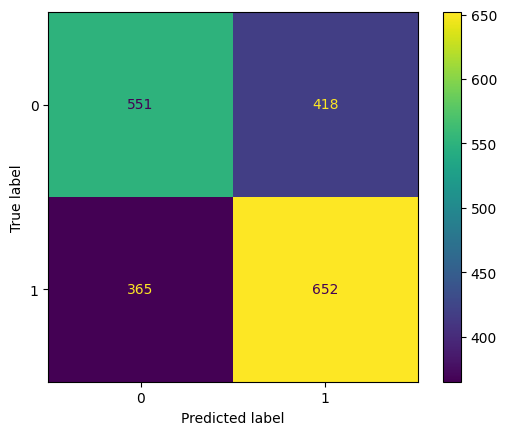

In [ ]:
cm = confusion_matrix(labels_test, labels_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

# Logistische Regression mit Transformer-Embeddings

## Featurematrix und Klassifizierer erstellen

In [ ]:
def featurematrix(dataset):

  # auskommentieren je nach Label-Anwendung

  # binär
  y_train = dataset_binary["train"]["labels"]
  y_test = dataset_binary["test"]["labels"]

  # multi Median
  #y_train = dataset_multi["train"]["labels"]
  #y_test = dataset_multi["test"]["labels"]

  # multi roundup
  #y_train = dataset_multi_roundup["train"]["labels"]
  #y_test = dataset_multi_roundup["test"]["labels"]

  X_train = np.array(dataset["train"]["hidden_state"])
  X_test = np.array(dataset["test"]["hidden_state"])

  lr_clf = LogisticRegression(class_weight='balanced', max_iter=10000)

  lr_clf.fit(X_train, y_train)

  y_pred = lr_clf.predict(X_test)
  score = lr_clf.score(X_test, y_test)
  score_f1 = f1_score(y_test, y_pred, average='macro')

  return X_train, y_train, X_test, y_test, score, score_f1

featurematrix(hidden_states)

(array([[ 0.4210119 , -0.23241891, -0.4268023 , ...,  0.24968423,
          0.65954214, -0.09563398],
        [ 0.49752688, -0.35853136, -0.55120194, ...,  0.2605666 ,
          0.8255819 , -0.15890326],
        [ 0.5217167 ,  0.01585298, -0.14059179, ..., -0.23564711,
          0.31440422, -0.02987738],
        ...,
        [ 0.41654086,  0.46925133, -0.09548496, ...,  0.34221488,
          0.4566423 , -0.6733247 ],
        [ 0.5096962 , -0.15765075, -0.64115876, ...,  0.03662411,
          0.27910173, -0.48190573],
        [ 0.3690399 , -0.33271143, -0.6515858 , ...,  0.2651591 ,
          0.70835805, -0.27326298]], dtype=float32),
 Column([0, 1, 1, 1, 1]),
 array([[ 0.3702431 , -0.4079046 , -0.59472734, ...,  0.38486224,
          0.76293284, -0.2196853 ],
        [ 0.3536443 , -0.61576307, -0.6607209 , ...,  0.38276446,
          0.8121718 , -0.20906556],
        [ 0.31681347, -0.37793958, -0.55637646, ...,  0.3869996 ,
          0.8942208 , -0.15709181],
        ...,
        [ 0.3

## Konfusionsmatrix erstellen

### Konfusionsmatrix für binäre Labels

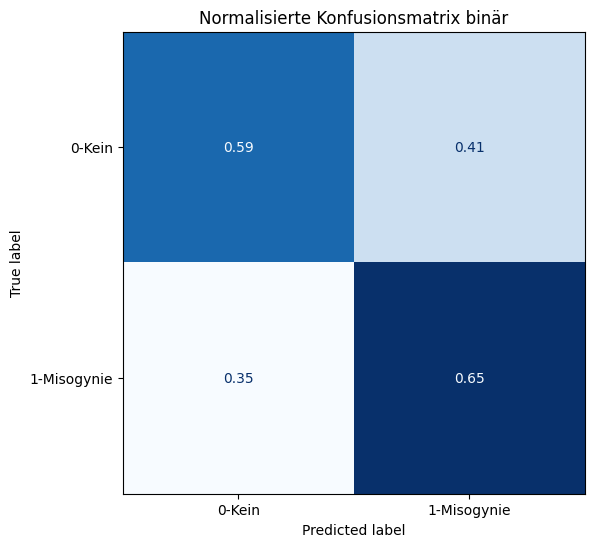


SCORE:
0.6203423967774421


In [ ]:
def matrix(X_train, y_train, X_test, y_test):

  def plot_confusion_matrix(y_preds, y_true, labels):
      cm = confusion_matrix(y_true, y_preds, labels=[0, 1], normalize='true')
      fig, ax = plt.subplots(figsize=(6,6))
      disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
      disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
      plt.title("Normalisierte Konfusionsmatrix binär")
      plt.show()

  lr_clf = LogisticRegression(class_weight='balanced', max_iter=10000)
  lr_clf.fit(X_train, y_train)
  y_preds = lr_clf.predict(X_test)
  class_labels = ["0-Kein", "1-Misogynie"]

  plot_confusion_matrix(y_preds, y_test, class_labels)

result = featurematrix(hidden_states)
X_train = result[0]
y_train = result[1]
X_test = result[2]
y_test = result[3]
score = result[4]

matrix(X_train, y_train, X_test, y_test)

print("\n" + "SCORE:")
print(score)

### Konfusionsmatrix für multi Labels

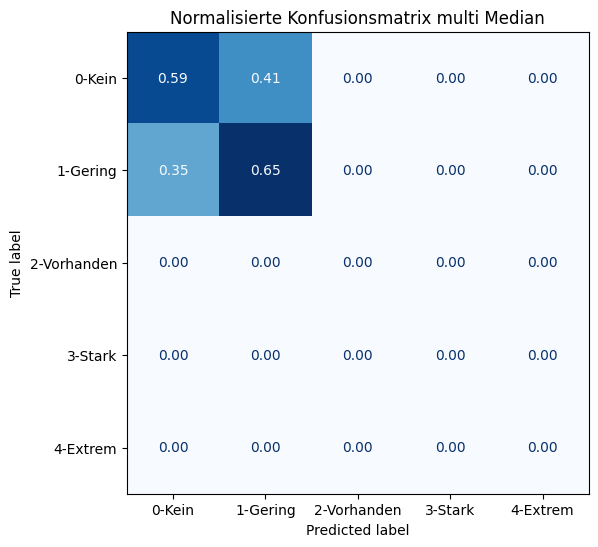


SCORE:
0.6203423967774421


In [ ]:
def matrix(X_train, y_train, X_test, y_test):

  def plot_confusion_matrix(y_preds, y_true, labels):
      cm = confusion_matrix(y_true, y_preds, labels=[0, 1, 2, 3, 4],normalize='true')
      fig, ax = plt.subplots(figsize=(6, 6))
      disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
      disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
      plt.title("Normalisierte Konfusionsmatrix multi Median")
      plt.show()

  lr_clf = LogisticRegression(class_weight='balanced', max_iter=10000)
  lr_clf.fit(X_train, y_train)
  y_preds = lr_clf.predict(X_test)
  class_labels = ["0-Kein", "1-Gering", "2-Vorhanden", "3-Stark", "4-Extrem"]

  plot_confusion_matrix(y_preds, y_test, class_labels)

result = featurematrix(hidden_states)
X_train = result[0]
y_train = result[1]
X_test = result[2]
y_test = result[3]
score = result[4]

matrix(X_train, y_train, X_test, y_test)

print("\n" + "SCORE:")
print(score)


# Fine-Tuning von BERT-Modellen

In [ ]:
os.environ["WANDB_DISABLED"] = "true"

### Validation Sets für die verschiedenen Datasets erstellen

In [ ]:
def create_train_val_test(dataset, val_size=0.1, seed=42):

    # Train/Validation Split erzeugen
    split = dataset["train"].train_test_split(test_size=val_size, seed=seed)

    # Neues DatasetDict bauen
    dataset_final = DatasetDict({
        "train": split["train"],
        "validation": split["test"],
        "test": dataset["test"]
    })

    return dataset_final

In [ ]:
# Validation Set für die Datasets ohne Zusatzfeature erstellen
dataset_binary_split = create_train_val_test(dataset_binary)
dataset_multi_split = create_train_val_test(dataset_multi)
dataset_multi_roundup_split = create_train_val_test(dataset_multi_roundup)

# Validation Set für die Datasets mit Zusatzfeature erstellen
dataset_binary_newfeature_split = create_train_val_test(dataset_binary_newfeature)
dataset_multi_newfeature_split = create_train_val_test(dataset_multi_newfeature)
dataset_multi_roundup_newfeature_split = create_train_val_test(dataset_multi_roundup_newfeature)

In [ ]:
# Neues Dictionary für Annotatoren-Datasets mit Validation-Set
datasets_per_annotator_split = {}

for annotator, ds in datasets_per_annotator.items():
    datasets_per_annotator_split[annotator] = create_train_val_test(ds, val_size=0.1, seed=42)

## Training

In [ ]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="macro")
    acc = accuracy_score(labels, preds)
    prec = precision_score(labels, preds, average="macro", zero_division=0)
    rec = recall_score(labels, preds, average="macro", zero_division=0)
    return {"accuracy": acc, "f1-macro": f1, "precision": prec, "recall": rec}

### BERT Modell für binäre Labels trainieren


In [ ]:
def model_training_binary(dataset):
  num_labels = 2
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  model_ckpt = "distilbert-base-german-cased"
  config = AutoConfig.from_pretrained(model_ckpt,
                                    num_labels=num_labels,
                                    hidden_dropout_prob=0.3,        # Feedforward-Dropout
                                    attention_probs_dropout_prob=0.3)  # Attention-Dropout
  tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
  model = (AutoModelForSequenceClassification
          .from_pretrained(model_ckpt, config=config)
          .to(device))

  batch_size = 16
  training_args = TrainingArguments(
                                    num_train_epochs=3,
                                    learning_rate=3.08e-5,
                                    per_device_train_batch_size=batch_size,
                                    per_device_eval_batch_size=batch_size,
                                    weight_decay=0.01,
                                    eval_strategy="epoch",
                                    disable_tqdm=False,
                                    logging_steps=10,
                                    push_to_hub=False,
                                    log_level="error")

  trainer = Trainer(model=model, args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=dataset["train"],
                  eval_dataset=dataset["validation"],
                  tokenizer=tokenizer)

  # Training + Validation
  trainer.train();

  # Finale Evaluation auf den Testdaten
  eval_result = trainer.evaluate(eval_dataset=dataset["test"]);
  print("Finale Evaluation auf Testdaten:\n")
  for key, value in eval_result.items():
    print(f"{key}: {value:.4f}")

model_training_binary(dataset_binary_split)


/tmp/ipython-input-4108684743.py:27: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model=model, args=training_args,


Epoch,Training Loss,Validation Loss,Accuracy,F1-macro,Precision,Recall
1,0.558300,0.529654,0.750000,0.743981,0.775952,0.750000
2,0.379200,0.542020,0.751667,0.750613,0.755993,0.751667
3,0.269400,0.618017,0.743333,0.743102,0.744212,0.743333


Finale Evaluation auf Testdaten:

eval_loss: 0.8106
eval_accuracy: 0.6788
eval_f1-macro: 0.6768
eval_precision: 0.6803
eval_recall: 0.6773
eval_runtime: 9.7560
eval_samples_per_second: 203.5660
eval_steps_per_second: 12.8130
epoch: 3.0000


### BERT Modell für Multi Median Labels trainieren


In [ ]:
def model_training_multi(dataset):
  num_labels = 5
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  model_ckpt = "distilbert-base-german-cased"
  tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
  config = AutoConfig.from_pretrained(model_ckpt,
                                    num_labels=num_labels,
                                    hidden_dropout_prob=0.3,        # Feedforward-Dropout
                                    attention_probs_dropout_prob=0.3)  # Attention-Dropout
  model = (AutoModelForSequenceClassification
          .from_pretrained(model_ckpt, config = config)
          .to(device))

  data_encoded = load_from_disk("data_encoded")
  batch_size = 16
  training_args = TrainingArguments(num_train_epochs=4,
                                    learning_rate=4.74e-5,
                                    per_device_train_batch_size=batch_size,
                                    per_device_eval_batch_size=batch_size,
                                    weight_decay=0.01,
                                    eval_strategy="epoch",
                                    disable_tqdm=False,
                                    logging_steps=10,
                                    push_to_hub=False,
                                    log_level="error")
  trainer = Trainer(model=model, args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=dataset["train"],
                  eval_dataset=dataset["validation"],
                  tokenizer=tokenizer)

  # Training + Validation
  trainer.train();

  # Finale Evaluation auf den Testdaten
  eval_result = trainer.evaluate(eval_dataset=dataset["test"]);
  print("Finale Evaluation auf Testdaten:\n")
  for key, value in eval_result.items():
    print(f"{key}: {value:.4f}")

model_training_multi(dataset_multi_split)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-german-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
/tmp/ipython-input-2128475573.py:26: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model=model, args=training_args,


Epoch,Training Loss,Validation Loss,Accuracy,F1-macro,Precision,Recall
1,0.995500,0.932454,0.635000,0.228124,0.201611,0.263129
2,0.888000,0.961026,0.608333,0.279971,0.309035,0.291331
3,0.622400,1.107750,0.585000,0.284935,0.331817,0.291823
4,0.590300,1.244835,0.593333,0.288729,0.339663,0.289906


Finale Evaluation auf Testdaten:

eval_loss: 1.4036
eval_accuracy: 0.5680
eval_f1-macro: 0.2799
eval_precision: 0.3174
eval_recall: 0.2787
eval_runtime: 9.4346
eval_samples_per_second: 210.5010
eval_steps_per_second: 13.2490
epoch: 4.0000


### BERT Modell für Multi Roundup Labels trainieren


In [ ]:
def model_training_multi(dataset):
  num_labels = 5
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  model_ckpt = "distilbert-base-german-cased"
  tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
  config = AutoConfig.from_pretrained(model_ckpt,
                                    num_labels=num_labels,
                                    hidden_dropout_prob=0.3,        # Feedforward-Dropout
                                    attention_probs_dropout_prob=0.3)  # Attention-Dropout
  model = (AutoModelForSequenceClassification
          .from_pretrained(model_ckpt, config = config)
          .to(device))

  data_encoded = load_from_disk("data_encoded")
  batch_size = 16
  training_args = TrainingArguments(num_train_epochs=3,
                                    learning_rate=4.98e-5,
                                    per_device_train_batch_size=batch_size,
                                    per_device_eval_batch_size=batch_size,
                                    weight_decay=0.01,
                                    eval_strategy="epoch",
                                    disable_tqdm=False,
                                    logging_steps=10,
                                    push_to_hub=False,
                                    log_level="error")
  trainer = Trainer(model=model, args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=dataset["train"],
                  eval_dataset=dataset["validation"],
                  tokenizer=tokenizer)

  # Training + Validation
  trainer.train();

  # Finale Evaluation auf den Testdaten
  eval_result = trainer.evaluate(eval_dataset=dataset["test"]);
  print("Finale Evaluation auf Testdaten:\n")
  for key, value in eval_result.items():
    print(f"{key}: {value:.4f}")

model_training_multi(dataset_multi_roundup_split)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-german-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
/tmp/ipython-input-4158622048.py:31: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model=model, args=training_args,


Epoch,Training Loss,Validation Loss,Accuracy,F1-macro,Precision,Recall
1,1.204600,1.122013,0.536667,0.293490,0.279706,0.321681
2,1.029300,1.153753,0.535000,0.339353,0.342284,0.348292
3,0.730900,1.263606,0.533333,0.345313,0.349514,0.348919


Finale Evaluation auf Testdaten:

eval_loss: 1.4655
eval_accuracy: 0.4587
eval_f1-macro: 0.2982
eval_precision: 0.2978
eval_recall: 0.3026
eval_runtime: 10.4537
eval_samples_per_second: 189.9800
eval_steps_per_second: 11.9570
epoch: 3.0000


### BERT Modell für individuelle Annotatoren trainieren


In [ ]:
def model_training_per_annotator(datasets):
  num_labels = 5
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  model_ckpt = "distilbert-base-german-cased"
  tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

  results = []

  for annotator, dataset in datasets.items():
    print(f"\n===== Training für Annotator {annotator} =====")

    # Neues Modell für jeden Annotator
    config = AutoConfig.from_pretrained(
        model_ckpt,
        num_labels=num_labels,
        hidden_dropout_prob=0.3,
        attention_probs_dropout_prob=0.3)

    model = (AutoModelForSequenceClassification
            .from_pretrained(model_ckpt, config=config)
            .to(device))

    batch_size = 8

    training_args = TrainingArguments(
            num_train_epochs=4,
            learning_rate=3.32e-05,
            save_strategy="no",
            per_device_train_batch_size=batch_size,
            per_device_eval_batch_size=batch_size,
            weight_decay=0.01,
            eval_strategy="epoch",
            disable_tqdm=False,
            logging_steps=10,
            push_to_hub=False,
            log_level="error")

    trainer = Trainer(
            model=model,
            args=training_args,
            compute_metrics=compute_metrics,
            train_dataset=dataset["train"],
            eval_dataset=dataset["validation"],
            tokenizer=tokenizer)

    # Training + Validation
    trainer.train();

    # Finale Evaluation auf den Testdaten
    eval_result = trainer.evaluate(eval_dataset=dataset["test"]);
    print(f"\nFinale Evaluation auf Testdaten für {annotator}:\n")
    for key, value in eval_result.items():
      print(f"{key}: {value:.4f}")

    results.append({
      'Annotator': annotator,
      'Modell': 'distilbert-base-german-cased (annotator A1)',
      'Accuracy': eval_result['eval_accuracy'],
      'Precision': eval_result['eval_precision'],
      'Recall': eval_result['eval_recall'],
      'F1-Score': eval_result['eval_f1-macro'],
      'learning-rate': 3.32e-05,
      'batch-size': batch_size,
      'epochs': 4})

  return results

all_results = model_training_per_annotator(datasets_per_annotator_split)


===== Training für Annotator a1 =====


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-german-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
/tmp/ipython-input-1071254.py:39: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1-macro,Precision,Recall
1,1.062800,0.907639,0.711340,0.195443,0.243158,0.216667
2,0.742000,0.901803,0.639175,0.217872,0.196999,0.259477
3,0.806000,0.996264,0.639175,0.218553,0.196757,0.259477
4,0.490700,1.057306,0.628866,0.215035,0.194260,0.256536



Finale Evaluation auf Testdaten für a1:

eval_loss: 1.5084
eval_accuracy: 0.4817
eval_f1-macro: 0.2341
eval_precision: 0.2274
eval_recall: 0.2602
eval_runtime: 1.7381
eval_samples_per_second: 188.7100
eval_steps_per_second: 23.5890
epoch: 4.0000

===== Training für Annotator a2 =====


/tmp/ipython-input-1071254.py:39: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1-macro,Precision,Recall
1,0.775500,0.724809,0.755000,0.172080,0.151000,0.200000
2,0.678500,0.752428,0.748333,0.241527,0.231764,0.253422
3,0.355500,1.018386,0.706667,0.244530,0.242993,0.248025
4,0.293900,1.116797,0.703333,0.236727,0.236372,0.238409



Finale Evaluation auf Testdaten für a2:

eval_loss: 1.3788
eval_accuracy: 0.6732
eval_f1-macro: 0.2537
eval_precision: 0.2957
eval_recall: 0.2519
eval_runtime: 10.3874
eval_samples_per_second: 191.1940
eval_steps_per_second: 23.9710
epoch: 4.0000

===== Training für Annotator a3 =====


/tmp/ipython-input-1071254.py:39: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1-macro,Precision,Recall
1,1.186600,1.258711,0.528000,0.138220,0.105600,0.200000
2,0.964200,1.090123,0.544000,0.232989,0.208824,0.290909
3,0.839400,1.088747,0.568000,0.243400,0.213248,0.306061
4,0.800900,1.098548,0.560000,0.246832,0.221698,0.315152



Finale Evaluation auf Testdaten für a3:

eval_loss: 1.4798
eval_accuracy: 0.4342
eval_f1-macro: 0.2218
eval_precision: 0.1986
eval_recall: 0.2904
eval_runtime: 2.5008
eval_samples_per_second: 182.3440
eval_steps_per_second: 22.7930
epoch: 4.0000

===== Training für Annotator a4 =====


/tmp/ipython-input-1071254.py:39: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1-macro,Precision,Recall
1,0.837700,1.213720,0.628571,0.154386,0.125714,0.200000
2,0.919900,1.131958,0.628571,0.154386,0.125714,0.200000
3,0.869000,1.059344,0.614286,0.198248,0.175347,0.228469
4,0.715400,1.156992,0.614286,0.190431,0.168769,0.220215



Finale Evaluation auf Testdaten für a4:

eval_loss: 1.3576
eval_accuracy: 0.5238
eval_f1-macro: 0.1851
eval_precision: 0.1592
eval_recall: 0.2215
eval_runtime: 2.6854
eval_samples_per_second: 187.6820
eval_steps_per_second: 23.4600
epoch: 4.0000

===== Training für Annotator a5 =====


/tmp/ipython-input-1071254.py:39: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1-macro,Precision,Recall
1,0.856800,1.008215,0.608974,0.162424,0.222078,0.205714
2,0.924600,0.972957,0.589744,0.168565,0.156643,0.202918
3,0.579300,1.088136,0.602564,0.220877,0.203333,0.243040
4,0.440200,1.182345,0.589744,0.225054,0.205217,0.249544



Finale Evaluation auf Testdaten für a5:

eval_loss: 1.3634
eval_accuracy: 0.5314
eval_f1-macro: 0.2073
eval_precision: 0.1868
eval_recall: 0.2333
eval_runtime: 2.9050
eval_samples_per_second: 186.5760
eval_steps_per_second: 23.4080
epoch: 4.0000

===== Training für Annotator a7 =====


/tmp/ipython-input-1071254.py:39: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1-macro,Precision,Recall
1,1.132200,1.110333,0.600000,0.179497,0.162537,0.212105
2,1.173700,1.056008,0.584000,0.209936,0.186231,0.243684
3,0.677800,1.190084,0.592000,0.216891,0.213439,0.234912
4,0.578900,1.272714,0.584000,0.221897,0.276620,0.239649



Finale Evaluation auf Testdaten für a7:

eval_loss: 1.3972
eval_accuracy: 0.5344
eval_f1-macro: 0.2225
eval_precision: 0.2220
eval_recall: 0.2478
eval_runtime: 2.4632
eval_samples_per_second: 183.0990
eval_steps_per_second: 23.1410
epoch: 4.0000

===== Training für Annotator a8 =====


/tmp/ipython-input-1071254.py:39: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1-macro,Precision,Recall
1,0.832800,0.747531,0.794595,0.177108,0.158919,0.200000
2,0.854400,0.693998,0.794595,0.177108,0.158919,0.200000
3,0.524300,0.706346,0.800000,0.284021,0.307937,0.277642
4,0.522500,0.785354,0.762162,0.277973,0.269219,0.287619



Finale Evaluation auf Testdaten für a8:

eval_loss: 1.1990
eval_accuracy: 0.6564
eval_f1-macro: 0.2263
eval_precision: 0.2315
eval_recall: 0.2351
eval_runtime: 3.4545
eval_samples_per_second: 187.8720
eval_steps_per_second: 23.7370
epoch: 4.0000

===== Training für Annotator a9 =====


/tmp/ipython-input-1071254.py:39: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1-macro,Precision,Recall
1,0.903200,0.943248,0.699659,0.164659,0.139932,0.200000
2,0.677100,0.962214,0.686007,0.198841,0.279090,0.214476
3,0.535800,1.226738,0.597270,0.225737,0.219065,0.233557
4,0.343000,1.346926,0.607509,0.233268,0.228125,0.240637



Finale Evaluation auf Testdaten für a9:

eval_loss: 1.1985
eval_accuracy: 0.6746
eval_f1-macro: 0.2314
eval_precision: 0.2405
eval_recall: 0.2388
eval_runtime: 5.0449
eval_samples_per_second: 192.4710
eval_steps_per_second: 24.1830
epoch: 4.0000

===== Training für Annotator a10 =====


/tmp/ipython-input-1071254.py:39: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1-macro,Precision,Recall
1,0.974900,0.909481,0.673333,0.204724,0.252348,0.223805
2,0.726300,0.954080,0.653333,0.266522,0.266172,0.271485
3,0.612400,1.177433,0.660000,0.275106,0.277367,0.278419
4,0.424500,1.309464,0.631667,0.272969,0.266242,0.280398



Finale Evaluation auf Testdaten für a10:

eval_loss: 1.3224
eval_accuracy: 0.6400
eval_f1-macro: 0.2874
eval_precision: 0.3339
eval_recall: 0.2923
eval_runtime: 10.4068
eval_samples_per_second: 190.8370
eval_steps_per_second: 23.9270
epoch: 4.0000

===== Training für Annotator a11 =====


/tmp/ipython-input-1071254.py:39: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1-macro,Precision,Recall
1,0.741200,0.778141,0.763441,0.216463,0.190860,0.250000
2,0.818300,0.784068,0.763441,0.216463,0.190860,0.250000
3,0.664700,0.783848,0.731183,0.244025,0.252841,0.258643
4,0.398600,0.851081,0.709677,0.241667,0.253676,0.251601



Finale Evaluation auf Testdaten für a11:

eval_loss: 0.4076
eval_accuracy: 0.8684
eval_f1-macro: 0.3128
eval_precision: 0.3300
eval_recall: 0.2973
eval_runtime: 0.5646
eval_samples_per_second: 201.9250
eval_steps_per_second: 26.5690
epoch: 4.0000

===== Training für Annotator a12 =====


/tmp/ipython-input-1071254.py:39: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1-macro,Precision,Recall
1,0.891900,0.960158,0.650000,0.220538,0.210747,0.242684
2,0.833500,1.015612,0.605000,0.236121,0.213128,0.283225
3,0.493500,1.213909,0.626667,0.229901,0.206046,0.261913
4,0.476300,1.312578,0.598333,0.258707,0.260662,0.273322



Finale Evaluation auf Testdaten für a12:

eval_loss: 1.4302
eval_accuracy: 0.5894
eval_f1-macro: 0.2809
eval_precision: 0.3160
eval_recall: 0.2866
eval_runtime: 8.8194
eval_samples_per_second: 188.3350
eval_steps_per_second: 23.5840
epoch: 4.0000


## Wortlisten-Regelkorrektur

### BERT Modell für binäre Labels trainieren + Wordlisten Funktion



In [ ]:
def model_training_binary_wordlist(dataset):
    num_labels = 2
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model_ckpt = "distilbert-base-german-cased"
    tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
    config = AutoConfig.from_pretrained(
        model_ckpt,
        num_labels=num_labels,
        hidden_dropout_prob=0.3,
        attention_probs_dropout_prob=0.3
    )
    model = (AutoModelForSequenceClassification
             .from_pretrained(model_ckpt, config=config)
             .to(device))

    batch_size = 16
    logging_steps = 10
    training_args = TrainingArguments(
        num_train_epochs=3,
        learning_rate=3.08e-5,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        weight_decay=0.01,
        eval_strategy="epoch",
        disable_tqdm=False,
        logging_steps=logging_steps,
        push_to_hub=False,
        log_level="error"
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        compute_metrics=compute_metrics,
        train_dataset=dataset["train"],
        eval_dataset=dataset["validation"],
        tokenizer=tokenizer
    )
    trainer.train()

    # --- Vorhersagen ---
    predictions = trainer.predict(dataset["test"])
    logits = predictions.predictions
    probs = torch.nn.functional.softmax(torch.tensor(logits), dim=1).numpy()
    predicted_labels = np.argmax(probs, axis=1)

    # Originaltexte und Labels
    texts = dataset["test"]["text"]
    true_labels = dataset["test"]["labels"]

    # --- Regelbasierte Korrektur nur bei Unsicherheit ---
    adjusted_preds = []
    for text, prob, pred in zip(texts, probs, predicted_labels):
        max_prob = np.max(prob)
        diff = abs(prob[0] - prob[1])

        # Bedingung: Modell unsicher
        if max_prob < 0.75 or diff < 0.1:
            if pred == 0 and any(word in text.lower() for word in sexist_words_filtered):
                adjusted_preds.append(1)  # Regel überschreibt
                continue

        # sonst normale Modellvorhersage
        adjusted_preds.append(pred)

    # --- Evaluation ---
    print("Ohne Regelkorrektur (nur Modell):\n")
    print(classification_report(true_labels, predicted_labels, digits=5))

    print("Mit Regelkorrektur bei Unsicherheit:\n")
    print(classification_report(true_labels, adjusted_preds, digits=5))

    # nebeneinander vergleichen (Precision/Recall/F1)
    metrics_model = precision_recall_fscore_support(true_labels, predicted_labels, average="macro")
    metrics_rules = precision_recall_fscore_support(true_labels, adjusted_preds, average="macro")

    print("Vergleich (Macro-Averages):")
    print(f"   Modell: Acc={accuracy_score(true_labels, predicted_labels):.4f}, "
          f"Prec={metrics_model[0]:.4f}, Rec={metrics_model[1]:.4f}, F1={metrics_model[2]:.4f}")
    print(f"   Hybrid: Acc={accuracy_score(true_labels, adjusted_preds):.4f}, "
          f"Prec={metrics_rules[0]:.4f}, Rec={metrics_rules[1]:.4f}, F1={metrics_rules[2]:.4f}")

model_training_binary_wordlist(dataset_binary_split)

/tmp/ipython-input-2460591189.py:33: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1-macro,Precision,Recall
1,0.554100,0.518432,0.750000,0.744756,0.772384,0.750000
2,0.365700,0.529701,0.748333,0.747823,0.750361,0.748333
3,0.294200,0.595801,0.741667,0.741350,0.742857,0.741667


Ohne Regelkorrektur (nur Modell):

              precision    recall  f1-score   support

           0    0.68884   0.59856   0.64053       969
           1    0.65997   0.74238   0.69875      1017

    accuracy                        0.67221      1986
   macro avg    0.67440   0.67047   0.66964      1986
weighted avg    0.67405   0.67221   0.67034      1986

Mit Regelkorrektur bei Unsicherheit:

              precision    recall  f1-score   support

           0    0.69512   0.58824   0.63723       969
           1    0.65780   0.75418   0.70270      1017

    accuracy                        0.67321      1986
   macro avg    0.67646   0.67121   0.66997      1986
weighted avg    0.67601   0.67321   0.67076      1986

Vergleich (Macro-Averages):
   Modell: Acc=0.6722, Prec=0.6744, Rec=0.6705, F1=0.6696
   Hybrid: Acc=0.6732, Prec=0.6765, Rec=0.6712, F1=0.6700


### BERT Modell für Multi Median Labels trainieren mit Wortlisten-Regelkorrektur

In [ ]:
def model_training_multimedian_wordlist(dataset):
    num_labels = 5
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model_ckpt = "distilbert-base-german-cased"
    tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
    config = AutoConfig.from_pretrained(
        model_ckpt,
        num_labels=num_labels,
        hidden_dropout_prob=0.3,
        attention_probs_dropout_prob=0.3
    )
    model = (AutoModelForSequenceClassification
             .from_pretrained(model_ckpt, config=config)
             .to(device))

    batch_size = 16
    logging_steps = 10
    training_args = TrainingArguments(
        num_train_epochs=4,
        learning_rate=4.74e-5,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        weight_decay=0.01,
        eval_strategy="epoch",
        disable_tqdm=False,
        logging_steps=logging_steps,
        push_to_hub=False,
        log_level="error"
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        compute_metrics=compute_metrics,
        train_dataset=dataset["train"],
        eval_dataset=dataset["validation"],
        tokenizer=tokenizer
    )
    trainer.train()

    # --- Vorhersagen auf den Testdaten ---
    predictions = trainer.predict(dataset["test"])
    logits = predictions.predictions
    probs = torch.nn.functional.softmax(torch.tensor(logits), dim=1).numpy()
    predicted_labels = np.argmax(probs, axis=1)

    # Originaltexte und Labels
    texts = dataset["test"]["text"]
    true_labels = dataset["test"]["labels"]

    # --- Regelbasierte Korrektur nur bei Unsicherheit ---
    adjusted_preds = []
    for text, prob, pred in zip(texts, probs, predicted_labels):
      max_prob = np.max(prob)
      # Unterschied zwischen Top-2-Klassen berechnen
      top2 = np.sort(prob)[-2:]
      diff = top2[1] - top2[0]

      # Bedingung: Modell unsicher
      if max_prob < 0.75 or diff < 0.1:
          text_lower = text.lower()
          if any(word in text_lower for word in sexist_words_filtered):
              new_label = min(pred + 1, num_labels - 1)  # max capped bei 4
              adjusted_preds.append(new_label)
              continue

      # sonst normale Modellvorhersage
      adjusted_preds.append(pred)

    # --- Evaluation ---
    print("Ohne Regelkorrektur (nur Modell):\n")
    print(classification_report(true_labels, predicted_labels, digits=5))

    print("Mit Regelkorrektur bei Unsicherheit (+1 Regel):\n")
    print(classification_report(true_labels, adjusted_preds, digits=5))

    # nebeneinander vergleichen (Precision/Recall/F1)
    metrics_model = precision_recall_fscore_support(true_labels, predicted_labels, average="macro")
    metrics_rules = precision_recall_fscore_support(true_labels, adjusted_preds, average="macro")

    print("Vergleich (Macro-Averages):")
    print(f"   Modell: Acc={accuracy_score(true_labels, predicted_labels):.4f}, "
          f"Prec={metrics_model[0]:.4f}, Rec={metrics_model[1]:.4f}, F1={metrics_model[2]:.4f}")
    print(f"   Hybrid: Acc={accuracy_score(true_labels, adjusted_preds):.4f}, "
          f"Prec={metrics_rules[0]:.4f}, Rec={metrics_rules[1]:.4f}, F1={metrics_rules[2]:.4f}")

model_training_multimedian_wordlist(dataset_multi_split)

/tmp/ipython-input-3259173034.py:33: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1-macro,Precision,Recall
1,0.990000,0.919897,0.626667,0.217297,0.193793,0.247306
2,0.858200,0.942480,0.608333,0.276467,0.264473,0.290528
3,0.554700,1.138915,0.570000,0.281061,0.318509,0.287704
4,0.513000,1.265193,0.580000,0.300391,0.345714,0.302964


Ohne Regelkorrektur (nur Modell):

              precision    recall  f1-score   support

           0    0.76690   0.72660   0.74621      1218
           1    0.21764   0.34421   0.26667       337
           2    0.26953   0.24468   0.25651       282
           3    0.32558   0.09790   0.15054       143
           4    0.00000   0.00000   0.00000         6

    accuracy                        0.54582      1986
   macro avg    0.31593   0.28268   0.28398      1986
weighted avg    0.56898   0.54582   0.55015      1986

Mit Regelkorrektur bei Unsicherheit (+1 Regel):

              precision    recall  f1-score   support

           0    0.76828   0.71593   0.74118      1218
           1    0.22013   0.31157   0.25799       337
           2    0.28244   0.26241   0.27206       282
           3    0.24742   0.16783   0.20000       143
           4    0.00000   0.00000   0.00000         6

    accuracy                        0.54129      1986
   macro avg    0.30365   0.29155   0.29425    

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m

Vergleich (Macro-Averages):
   Modell: Acc=0.5458, Prec=0.3159, Rec=0.2827, F1=0.2840
   Hybrid: Acc=0.5413, Prec=0.3037, Rec=0.2915, F1=0.2942


### BERT Modell für Multi Roundup Labels trainieren mit Wortlisten-Regelkorrektur

In [ ]:
def model_training_multiroundup_wordlist(dataset):
    num_labels = 5
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model_ckpt = "distilbert-base-german-cased"
    tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
    config = AutoConfig.from_pretrained(
        model_ckpt,
        num_labels=num_labels,
        hidden_dropout_prob=0.3,
        attention_probs_dropout_prob=0.3
    )
    model = (AutoModelForSequenceClassification
             .from_pretrained(model_ckpt, config=config)
             .to(device))

    batch_size = 16
    logging_steps = 10
    training_args = TrainingArguments(
        num_train_epochs=3,
        learning_rate=4.98e-5,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        weight_decay=0.01,
        eval_strategy="epoch",
        disable_tqdm=False,
        logging_steps=logging_steps,
        push_to_hub=False,
        log_level="error"
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        compute_metrics=compute_metrics,
        train_dataset=dataset["train"],
        eval_dataset=dataset["validation"],
        tokenizer=tokenizer
    )
    trainer.train()

    # --- Vorhersagen auf den Testdaten ---
    predictions = trainer.predict(dataset["test"])
    logits = predictions.predictions
    probs = torch.nn.functional.softmax(torch.tensor(logits), dim=1).numpy()
    predicted_labels = np.argmax(probs, axis=1)

    # Originaltexte und Labels
    texts = dataset["test"]["text"]
    true_labels = dataset["test"]["labels"]

    # --- Regelbasierte Korrektur nur bei Unsicherheit ---
    adjusted_preds = []
    for text, prob, pred in zip(texts, probs, predicted_labels):
      max_prob = np.max(prob)
      # Unterschied zwischen Top-2-Klassen berechnen
      top2 = np.sort(prob)[-2:]
      diff = top2[1] - top2[0]

      # Bedingung: Modell unsicher
      if max_prob < 0.75 or diff < 0.1:
          text_lower = text.lower()
          if any(word in text_lower for word in sexist_words_filtered):
              new_label = min(pred + 1, num_labels - 1)  # max capped bei 4
              adjusted_preds.append(new_label)
              continue

      # sonst normale Modellvorhersage
      adjusted_preds.append(pred)

    # --- Evaluation ---
    print("Ohne Regelkorrektur (nur Modell):\n")
    print(classification_report(true_labels, predicted_labels, digits=5))

    print("Mit Regelkorrektur bei Unsicherheit (+1 Regel):\n")
    print(classification_report(true_labels, adjusted_preds, digits=5))

    # nebeneinander vergleichen (Precision/Recall/F1)
    metrics_model = precision_recall_fscore_support(true_labels, predicted_labels, average="macro")
    metrics_rules = precision_recall_fscore_support(true_labels, adjusted_preds, average="macro")

    print("Vergleich (Macro-Averages):")
    print(f"   Modell: Acc={accuracy_score(true_labels, predicted_labels):.4f}, "
          f"Prec={metrics_model[0]:.4f}, Rec={metrics_model[1]:.4f}, F1={metrics_model[2]:.4f}")
    print(f"   Hybrid: Acc={accuracy_score(true_labels, adjusted_preds):.4f}, "
          f"Prec={metrics_rules[0]:.4f}, Rec={metrics_rules[1]:.4f}, F1={metrics_rules[2]:.4f}")

model_training_multiroundup_wordlist(dataset_multi_roundup_split)

/tmp/ipython-input-950511340.py:33: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1-macro,Precision,Recall
1,1.216900,1.127044,0.536667,0.293991,0.275668,0.317268
2,1.052700,1.152068,0.531667,0.329683,0.332513,0.339959
3,0.730100,1.241359,0.518333,0.324861,0.323927,0.330593


Ohne Regelkorrektur (nur Modell):

              precision    recall  f1-score   support

           0    0.68043   0.64603   0.66278       969
           1    0.25235   0.33924   0.28942       395
           2    0.32021   0.33152   0.32577       368
           3    0.24183   0.20442   0.22156       181
           4    0.00000   0.00000   0.00000        73

    accuracy                        0.46274      1986
   macro avg    0.29897   0.30424   0.29991      1986
weighted avg    0.46356   0.46274   0.46150      1986

Mit Regelkorrektur bei Unsicherheit (+1 Regel):

              precision    recall  f1-score   support

           0    0.68603   0.63364   0.65880       969
           1    0.24580   0.29620   0.26866       395
           2    0.27887   0.26902   0.27386       368
           3    0.20362   0.24862   0.22388       181
           4    0.23077   0.12329   0.16071        73

    accuracy                        0.44512      1986
   macro avg    0.32902   0.31415   0.31718    

## Wortliste als zusätzliches Feature

Neues DistilBERT-Modell erstellen, welches das neue "has_sexist_word" Feature im Datensatz erkennt und verarbeiten kann

In [ ]:
class DistilBertWithFeature(nn.Module):
    def __init__(self, model_name, num_labels, dropout_rate=0.3):
        super().__init__()
        self.bert = DistilBertModel.from_pretrained(model_name)
        self.feature_proj = nn.Linear(1, 8)  # projiziert das Zusatzfeature auf 8 Dimensionen
        self.dropout = nn.Dropout(dropout_rate)  # Dropout-Layer
        self.classifier = nn.Linear(self.bert.config.hidden_size + 8, num_labels)

    def forward(self, input_ids, attention_mask, has_sexist_word, labels=None):
        # BERT-Forward
        bert_outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = bert_outputs.last_hidden_state[:, 0]  # CLS-Token

        # Extra Feature
        extra_feature = self.feature_proj(has_sexist_word.unsqueeze(1).float())

        # Dropout anwenden
        pooled_output = self.dropout(pooled_output)

        # Kombinieren und Klassifizieren
        combined = torch.cat((pooled_output, extra_feature), dim=1)
        logits = self.classifier(combined)

        # Loss berechnen (falls Labels vorhanden)
        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits, labels)

        return {"loss": loss, "logits": logits}

Der Data-Collator erstellt ein Batch, paddet automatisch die Eingabesequenzen und fügt das Zusatzlabel "has_sexist_word" wieder hinzu, damit das Modell beides zusammen verarbeiten kann

In [ ]:
class DataCollatorWithFeature(DataCollatorWithPadding):
    def __call__(self, features):
        has_sexist_word = [f["has_sexist_word"] for f in features]
        for f in features:
            del f["has_sexist_word"]
        batch = super().__call__(features)
        batch["has_sexist_word"] = torch.tensor(has_sexist_word)
        return batch

### BERT Modell für binäre Labels trainieren mit zusätzlicher Wortliste als Feature

In [ ]:
def model_training_wordlist_binary(dataset):
  num_labels = 2
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  model_ckpt = "distilbert-base-german-cased"
  tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
  data_collator = DataCollatorWithFeature(tokenizer)
  model = DistilBertWithFeature("distilbert-base-german-cased", num_labels=2)

  data_encoded = load_from_disk("data_encoded")
  batch_size = 16
  logging_steps = 10
  training_args = TrainingArguments(num_train_epochs=3,
                                    learning_rate=3.08e-5,
                                    per_device_train_batch_size=batch_size,
                                    per_device_eval_batch_size=batch_size,
                                    weight_decay=0.01,
                                    eval_strategy="epoch",
                                    disable_tqdm=False,
                                    logging_steps=logging_steps,
                                    push_to_hub=False,
                                    log_level="error")
  trainer = Trainer(model=model, args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=dataset["train"],
                  eval_dataset=dataset["validation"],
                  tokenizer=tokenizer, data_collator=data_collator)
  trainer.train();

  # Finale Evaluation auf den Testdaten
  eval_result = trainer.evaluate(eval_dataset=dataset["test"]);
  print("Finale Evaluation auf Testdaten:\n")
  for key, value in eval_result.items():
    print(f"{key}: {value:.4f}")

model_training_wordlist_binary(dataset_binary_newfeature_split)

/tmp/ipython-input-2618233685.py:24: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model=model, args=training_args,


Epoch,Training Loss,Validation Loss,Accuracy,F1-macro,Precision,Recall
1,0.579700,0.527430,0.758333,0.753847,0.778647,0.758333
2,0.402700,0.542208,0.738333,0.737633,0.740906,0.738333
3,0.307100,0.652108,0.728333,0.728296,0.728458,0.728333


Finale Evaluation auf Testdaten:

eval_loss: 0.8557
eval_accuracy: 0.6742
eval_f1-macro: 0.6726
eval_precision: 0.6752
eval_recall: 0.6729
eval_runtime: 9.8082
eval_samples_per_second: 202.4840
eval_steps_per_second: 12.7440
epoch: 3.0000


### BERT Modell für Multi Median Labels trainieren mit zusätzlicher Wortliste als Feature

In [ ]:
def model_training_wordlist_multi(dataset):
  num_labels = 5
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  model_ckpt = "distilbert-base-german-cased"
  tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
  data_collator = DataCollatorWithFeature(tokenizer)
  model = DistilBertWithFeature("distilbert-base-german-cased", num_labels=5)

  data_encoded = load_from_disk("data_encoded")
  batch_size = 16
  logging_steps = 10
  training_args = TrainingArguments(num_train_epochs=4,
                                    learning_rate=4.74e-5,
                                    per_device_train_batch_size=batch_size,
                                    per_device_eval_batch_size=batch_size,
                                    weight_decay=0.01,
                                    eval_strategy="epoch",
                                    disable_tqdm=False,
                                    logging_steps=logging_steps,
                                    push_to_hub=False,
                                    log_level="error")
  trainer = Trainer(model=model, args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=dataset["train"],
                  eval_dataset=dataset["validation"],
                  tokenizer=tokenizer, data_collator=data_collator)
  trainer.train();

  # Finale Evaluation auf den Testdaten
  eval_result = trainer.evaluate(eval_dataset=dataset["test"]);
  print("Finale Evaluation auf Testdaten:\n")
  for key, value in eval_result.items():
    print(f"{key}: {value:.4f}")

model_training_wordlist_multi(dataset_multi_newfeature_split)

model.safetensors:   0%|          | 0.00/270M [00:00<?, ?B/s]

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
/tmp/ipython-input-4172618562.py:24: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model=model, args=training_args,


Epoch,Training Loss,Validation Loss,Accuracy,F1-macro,Precision,Recall
1,0.984600,0.913006,0.628333,0.208155,0.188564,0.234616
2,0.838800,0.947993,0.625000,0.280028,0.315450,0.276621
3,0.523200,1.182654,0.571667,0.285862,0.351003,0.287252
4,0.396900,1.335907,0.591667,0.306214,0.354447,0.299452


Finale Evaluation auf Testdaten:

eval_loss: 1.5384
eval_accuracy: 0.5609
eval_f1-macro: 0.2958
eval_precision: 0.3235
eval_recall: 0.2917
eval_runtime: 10.4549
eval_samples_per_second: 189.9590
eval_steps_per_second: 11.9560
epoch: 4.0000


### BERT Modell für Multi Roundup Labels trainieren mit zusätzlicher Wortliste als Feature

In [ ]:
def model_training_wordlist_multiroundup(dataset):
  num_labels = 5
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  model_ckpt = "distilbert-base-german-cased"
  tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
  data_collator = DataCollatorWithFeature(tokenizer)
  model = DistilBertWithFeature("distilbert-base-german-cased", num_labels=5)

  data_encoded = load_from_disk("data_encoded")
  batch_size = 16
  logging_steps = 10
  training_args = TrainingArguments(num_train_epochs=3,
                                    learning_rate=4.98e-5,
                                    #learning_rate=3e-5,
                                    per_device_train_batch_size=batch_size,
                                    per_device_eval_batch_size=batch_size,
                                    weight_decay=0.01,
                                    eval_strategy="epoch",
                                    disable_tqdm=False,
                                    logging_steps=logging_steps,
                                    push_to_hub=False,
                                    log_level="error")
  trainer = Trainer(model=model, args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=dataset["train"],
                  eval_dataset=dataset["validation"],
                  tokenizer=tokenizer, data_collator=data_collator)
  trainer.train();

  # Finale Evaluation auf den Testdaten
  eval_result = trainer.evaluate(eval_dataset=dataset["test"]);
  print("Finale Evaluation auf Testdaten:\n")
  for key, value in eval_result.items():
    print(f"{key}: {value:.4f}")

model_training_wordlist_multiroundup(dataset_multi_roundup_newfeature_split)

/tmp/ipython-input-2253699933.py:25: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model=model, args=training_args,


Epoch,Training Loss,Validation Loss,Accuracy,F1-macro,Precision,Recall
1,1.204000,1.123905,0.541667,0.298935,0.281540,0.325888
2,0.985400,1.178827,0.521667,0.323804,0.321931,0.333410
3,0.695300,1.328515,0.508333,0.315298,0.312345,0.320164


Finale Evaluation auf Testdaten:

eval_loss: 1.5423
eval_accuracy: 0.4527
eval_f1-macro: 0.2895
eval_precision: 0.3254
eval_recall: 0.2910
eval_runtime: 10.2024
eval_samples_per_second: 194.6600
eval_steps_per_second: 12.2520
epoch: 3.0000


## Parameter Optimierung mit Optuna

### Parameter Optimierung mit Optuna für den binären Datensatz

In [ ]:
def model_training_optuna_binary(trial):
  num_labels = 2
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  model_ckpt = "distilbert-base-german-cased"
  tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
  config = AutoConfig.from_pretrained(model_ckpt,
                                     num_labels=num_labels,
                                     hidden_dropout_prob=0.3,        # Feedforward-Dropout
                                     attention_probs_dropout_prob=0.3)  # Attention-Dropout
  model = (AutoModelForSequenceClassification
          .from_pretrained(model_ckpt, config = config)
          .to(device))

  learning_rate = trial.suggest_float("learning_rate", 1e-5, 5e-5, log=True)
  batch_size = trial.suggest_categorical("batch_size", [8, 16, 32])
  num_epochs = trial.suggest_int("num_train_epochs", 2, 4)

  training_args = TrainingArguments(
      eval_strategy="epoch",
      save_strategy="no",
      learning_rate=learning_rate,
      per_device_train_batch_size=batch_size,
      per_device_eval_batch_size=batch_size,
      num_train_epochs=num_epochs,
      weight_decay=0.01,
      disable_tqdm=False,
      logging_steps=10,
      push_to_hub=False,
      log_level="error"
  )


  trainer = Trainer(model=model, args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=dataset_binary_split["train"],
                  eval_dataset=dataset_binary_split["validation"],
                  tokenizer=tokenizer)

  # Training + Validation
  trainer.train();

  # Finale Evaluation
  eval_result = trainer.evaluate(eval_dataset=dataset_binary_split["validation"]);

  print(eval_result)
  return eval_result["eval_f1-macro"]

In [ ]:
study = optuna.create_study(direction="maximize")  # Maximieren von F1
study.optimize(model_training_optuna_binary, n_trials=20)  # 20 verschiedene Kombinationen testen

print("Beste Hyperparameter:", study.best_params)

[I 2025-09-20 21:18:55,910] A new study created in memory with name: no-name-6f5bc35d-3d1a-4525-a55d-d31c05d474dd
/tmp/ipython-input-1892351867.py:43: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model=model, args=training_args,


Epoch,Training Loss,Validation Loss,Accuracy,F1-macro,Precision,Recall
1,0.595000,0.593199,0.696667,0.696613,0.696807,0.696667
2,0.505600,0.541014,0.721667,0.720922,0.724059,0.721667
3,0.490200,0.532123,0.731667,0.731451,0.732413,0.731667
4,0.477900,0.535574,0.740000,0.738463,0.745779,0.740000


[I 2025-09-20 21:25:57,305] Trial 0 finished with value: 0.7384627421175576 and parameters: {'learning_rate': 1.3488069074643334e-05, 'batch_size': 16, 'num_train_epochs': 4}. Best is trial 0 with value: 0.7384627421175576.


{'eval_loss': 0.5355739593505859, 'eval_accuracy': 0.74, 'eval_f1-macro': 0.7384627421175576, 'eval_precision': 0.7457785262391334, 'eval_recall': 0.74, 'eval_runtime': 4.0479, 'eval_samples_per_second': 148.225, 'eval_steps_per_second': 2.47, 'epoch': 4.0}


/tmp/ipython-input-1892351867.py:43: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model=model, args=training_args,


Epoch,Training Loss,Validation Loss,Accuracy,F1-macro,Precision,Recall
1,0.593400,0.597011,0.711667,0.710792,0.714259,0.711667
2,0.500300,0.542268,0.735000,0.734196,0.737878,0.735000
3,0.486400,0.534241,0.735000,0.734911,0.735316,0.735000
4,0.469300,0.538324,0.736667,0.735370,0.741398,0.736667


[I 2025-09-20 21:33:00,064] Trial 1 finished with value: 0.7353699795665427 and parameters: {'learning_rate': 1.4646952625967629e-05, 'batch_size': 8, 'num_train_epochs': 4}. Best is trial 0 with value: 0.7384627421175576.


{'eval_loss': 0.5383239984512329, 'eval_accuracy': 0.7366666666666667, 'eval_f1-macro': 0.7353699795665427, 'eval_precision': 0.7413980688154496, 'eval_recall': 0.7366666666666666, 'eval_runtime': 4.0596, 'eval_samples_per_second': 147.799, 'eval_steps_per_second': 2.463, 'epoch': 4.0}


/tmp/ipython-input-1892351867.py:43: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model=model, args=training_args,


Epoch,Training Loss,Validation Loss,Accuracy,F1-macro,Precision,Recall
1,0.621400,0.620542,0.688333,0.688332,0.688335,0.688333
2,0.553100,0.580968,0.713333,0.713014,0.714286,0.713333


[I 2025-09-20 21:36:34,874] Trial 2 finished with value: 0.7130144605116796 and parameters: {'learning_rate': 1.3560223034395535e-05, 'batch_size': 8, 'num_train_epochs': 2}. Best is trial 0 with value: 0.7384627421175576.


{'eval_loss': 0.5809677243232727, 'eval_accuracy': 0.7133333333333334, 'eval_f1-macro': 0.7130144605116796, 'eval_precision': 0.7142857142857142, 'eval_recall': 0.7133333333333334, 'eval_runtime': 4.0564, 'eval_samples_per_second': 147.914, 'eval_steps_per_second': 2.465, 'epoch': 2.0}


/tmp/ipython-input-1892351867.py:43: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model=model, args=training_args,


Epoch,Training Loss,Validation Loss,Accuracy,F1-macro,Precision,Recall
1,0.572200,0.574813,0.700000,0.699730,0.700723,0.700000
2,0.509700,0.552009,0.716667,0.715754,0.719486,0.716667


[I 2025-09-20 21:40:09,932] Trial 3 finished with value: 0.7157539209238555 and parameters: {'learning_rate': 1.843826213116862e-05, 'batch_size': 32, 'num_train_epochs': 2}. Best is trial 0 with value: 0.7384627421175576.


{'eval_loss': 0.5520088076591492, 'eval_accuracy': 0.7166666666666667, 'eval_f1-macro': 0.7157539209238555, 'eval_precision': 0.7194858403493765, 'eval_recall': 0.7166666666666667, 'eval_runtime': 4.0779, 'eval_samples_per_second': 147.136, 'eval_steps_per_second': 2.452, 'epoch': 2.0}


/tmp/ipython-input-1892351867.py:43: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model=model, args=training_args,


Epoch,Training Loss,Validation Loss,Accuracy,F1-macro,Precision,Recall
1,0.634700,0.630604,0.668333,0.668126,0.668755,0.668333
2,0.542700,0.568088,0.705000,0.703616,0.708902,0.705000
3,0.534600,0.556403,0.710000,0.708952,0.713068,0.710000


[I 2025-09-20 21:45:28,423] Trial 4 finished with value: 0.7089522280208751 and parameters: {'learning_rate': 1.0550028745204036e-05, 'batch_size': 16, 'num_train_epochs': 3}. Best is trial 0 with value: 0.7384627421175576.


{'eval_loss': 0.5564032196998596, 'eval_accuracy': 0.71, 'eval_f1-macro': 0.7089522280208751, 'eval_precision': 0.7130681818181819, 'eval_recall': 0.71, 'eval_runtime': 4.0519, 'eval_samples_per_second': 148.079, 'eval_steps_per_second': 2.468, 'epoch': 3.0}


/tmp/ipython-input-1892351867.py:43: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model=model, args=training_args,


Epoch,Training Loss,Validation Loss,Accuracy,F1-macro,Precision,Recall
1,0.564200,0.563335,0.726667,0.725051,0.732124,0.726667
2,0.486100,0.535267,0.736667,0.736312,0.737946,0.736667
3,0.476400,0.537124,0.736667,0.734825,0.743429,0.736667


[I 2025-09-20 21:50:47,244] Trial 5 finished with value: 0.7348251748251748 and parameters: {'learning_rate': 1.890776388177736e-05, 'batch_size': 16, 'num_train_epochs': 3}. Best is trial 0 with value: 0.7384627421175576.


{'eval_loss': 0.5371240377426147, 'eval_accuracy': 0.7366666666666667, 'eval_f1-macro': 0.7348251748251748, 'eval_precision': 0.7434285714285714, 'eval_recall': 0.7366666666666666, 'eval_runtime': 4.0678, 'eval_samples_per_second': 147.498, 'eval_steps_per_second': 2.458, 'epoch': 3.0}


/tmp/ipython-input-1892351867.py:43: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model=model, args=training_args,


Epoch,Training Loss,Validation Loss,Accuracy,F1-macro,Precision,Recall
1,0.630600,0.628280,0.681667,0.681595,0.681830,0.681667
2,0.531800,0.566578,0.725000,0.724061,0.728105,0.725000
3,0.525300,0.555153,0.730000,0.729024,0.733360,0.730000


[I 2025-09-20 21:56:05,774] Trial 6 finished with value: 0.7290244881573664 and parameters: {'learning_rate': 1.077766357565225e-05, 'batch_size': 16, 'num_train_epochs': 3}. Best is trial 0 with value: 0.7384627421175576.


{'eval_loss': 0.5551526546478271, 'eval_accuracy': 0.73, 'eval_f1-macro': 0.7290244881573664, 'eval_precision': 0.7333603896103896, 'eval_recall': 0.73, 'eval_runtime': 4.0537, 'eval_samples_per_second': 148.014, 'eval_steps_per_second': 2.467, 'epoch': 3.0}


/tmp/ipython-input-1892351867.py:43: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model=model, args=training_args,


Epoch,Training Loss,Validation Loss,Accuracy,F1-macro,Precision,Recall
1,0.580200,0.578824,0.708333,0.707553,0.710582,0.708333
2,0.494900,0.539927,0.736667,0.736245,0.738191,0.736667
3,0.489000,0.540105,0.735000,0.733364,0.740913,0.735000


[I 2025-09-20 22:01:24,370] Trial 7 finished with value: 0.7333638912102316 and parameters: {'learning_rate': 1.625536961077184e-05, 'batch_size': 8, 'num_train_epochs': 3}. Best is trial 0 with value: 0.7384627421175576.


{'eval_loss': 0.5401054620742798, 'eval_accuracy': 0.735, 'eval_f1-macro': 0.7333638912102316, 'eval_precision': 0.7409130776503285, 'eval_recall': 0.735, 'eval_runtime': 4.071, 'eval_samples_per_second': 147.382, 'eval_steps_per_second': 2.456, 'epoch': 3.0}


/tmp/ipython-input-1892351867.py:43: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model=model, args=training_args,


Epoch,Training Loss,Validation Loss,Accuracy,F1-macro,Precision,Recall
1,0.598500,0.597804,0.711667,0.711313,0.712709,0.711667
2,0.506300,0.546291,0.738333,0.737802,0.740280,0.738333
3,0.502100,0.544670,0.741667,0.740455,0.746266,0.741667


[I 2025-09-20 22:06:43,023] Trial 8 finished with value: 0.7404547344684485 and parameters: {'learning_rate': 1.397088272572914e-05, 'batch_size': 16, 'num_train_epochs': 3}. Best is trial 8 with value: 0.7404547344684485.


{'eval_loss': 0.5446701049804688, 'eval_accuracy': 0.7416666666666667, 'eval_f1-macro': 0.7404547344684485, 'eval_precision': 0.7462663752986334, 'eval_recall': 0.7416666666666667, 'eval_runtime': 4.0635, 'eval_samples_per_second': 147.655, 'eval_steps_per_second': 2.461, 'epoch': 3.0}


/tmp/ipython-input-1892351867.py:43: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model=model, args=training_args,


Epoch,Training Loss,Validation Loss,Accuracy,F1-macro,Precision,Recall
1,0.573700,0.572424,0.723333,0.722334,0.726596,0.723333
2,0.491300,0.538085,0.740000,0.739650,0.741298,0.740000
3,0.483800,0.538950,0.738333,0.736718,0.744330,0.738333


[I 2025-09-20 22:12:01,586] Trial 9 finished with value: 0.736717804528342 and parameters: {'learning_rate': 1.72350213832113e-05, 'batch_size': 32, 'num_train_epochs': 3}. Best is trial 8 with value: 0.7404547344684485.


{'eval_loss': 0.5389495491981506, 'eval_accuracy': 0.7383333333333333, 'eval_f1-macro': 0.736717804528342, 'eval_precision': 0.7443302844255106, 'eval_recall': 0.7383333333333333, 'eval_runtime': 4.0439, 'eval_samples_per_second': 148.372, 'eval_steps_per_second': 2.473, 'epoch': 3.0}


/tmp/ipython-input-1892351867.py:43: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model=model, args=training_args,


Epoch,Training Loss,Validation Loss,Accuracy,F1-macro,Precision,Recall
1,0.545000,0.548606,0.735000,0.729309,0.756578,0.735000
2,0.450600,0.523640,0.751667,0.750262,0.757460,0.751667
3,0.402000,0.536020,0.745000,0.744999,0.745003,0.745000
4,0.360400,0.559998,0.755000,0.754257,0.758123,0.755000


[I 2025-09-20 22:19:03,993] Trial 10 finished with value: 0.7542566262945409 and parameters: {'learning_rate': 3.079784998948728e-05, 'batch_size': 16, 'num_train_epochs': 4}. Best is trial 10 with value: 0.7542566262945409.


{'eval_loss': 0.559998095035553, 'eval_accuracy': 0.755, 'eval_f1-macro': 0.7542566262945409, 'eval_precision': 0.758123291831157, 'eval_recall': 0.755, 'eval_runtime': 4.0588, 'eval_samples_per_second': 147.827, 'eval_steps_per_second': 2.464, 'epoch': 4.0}


/tmp/ipython-input-1892351867.py:43: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model=model, args=training_args,


Epoch,Training Loss,Validation Loss,Accuracy,F1-macro,Precision,Recall
1,0.538900,0.555427,0.733333,0.727471,0.755301,0.733333
2,0.452400,0.523891,0.750000,0.748884,0.754525,0.750000
3,0.397400,0.538247,0.738333,0.738327,0.738357,0.738333
4,0.349600,0.557765,0.745000,0.744483,0.747001,0.745000


[I 2025-09-20 22:26:06,325] Trial 11 finished with value: 0.7444825772188681 and parameters: {'learning_rate': 3.1443073355236995e-05, 'batch_size': 16, 'num_train_epochs': 4}. Best is trial 10 with value: 0.7542566262945409.


{'eval_loss': 0.5577653050422668, 'eval_accuracy': 0.745, 'eval_f1-macro': 0.7444825772188681, 'eval_precision': 0.7470007057163021, 'eval_recall': 0.745, 'eval_runtime': 4.0832, 'eval_samples_per_second': 146.944, 'eval_steps_per_second': 2.449, 'epoch': 4.0}


/tmp/ipython-input-1892351867.py:43: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model=model, args=training_args,


Epoch,Training Loss,Validation Loss,Accuracy,F1-macro,Precision,Recall
1,0.535900,0.549730,0.736667,0.731402,0.756800,0.736667
2,0.447800,0.521502,0.750000,0.748884,0.754525,0.750000
3,0.384900,0.540341,0.741667,0.741631,0.741798,0.741667
4,0.333300,0.561865,0.745000,0.744483,0.747001,0.745000


[I 2025-09-20 22:33:08,767] Trial 12 finished with value: 0.7444825772188681 and parameters: {'learning_rate': 3.372193830515752e-05, 'batch_size': 16, 'num_train_epochs': 4}. Best is trial 10 with value: 0.7542566262945409.


{'eval_loss': 0.5618647336959839, 'eval_accuracy': 0.745, 'eval_f1-macro': 0.7444825772188681, 'eval_precision': 0.7470007057163021, 'eval_recall': 0.745, 'eval_runtime': 4.0641, 'eval_samples_per_second': 147.633, 'eval_steps_per_second': 2.461, 'epoch': 4.0}


/tmp/ipython-input-1892351867.py:43: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model=model, args=training_args,


Epoch,Training Loss,Validation Loss,Accuracy,F1-macro,Precision,Recall
1,0.538900,0.553506,0.736667,0.731402,0.756800,0.736667
2,0.451000,0.523431,0.750000,0.748769,0.754998,0.750000
3,0.394600,0.539005,0.736667,0.736640,0.736761,0.736667
4,0.346600,0.558028,0.745000,0.744317,0.747644,0.745000


[I 2025-09-20 22:40:11,040] Trial 13 finished with value: 0.7443174696899223 and parameters: {'learning_rate': 3.1968037099769264e-05, 'batch_size': 16, 'num_train_epochs': 4}. Best is trial 10 with value: 0.7542566262945409.


{'eval_loss': 0.5580276250839233, 'eval_accuracy': 0.745, 'eval_f1-macro': 0.7443174696899223, 'eval_precision': 0.7476442907040735, 'eval_recall': 0.745, 'eval_runtime': 4.0578, 'eval_samples_per_second': 147.863, 'eval_steps_per_second': 2.464, 'epoch': 4.0}


/tmp/ipython-input-1892351867.py:43: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model=model, args=training_args,


Epoch,Training Loss,Validation Loss,Accuracy,F1-macro,Precision,Recall
1,0.534500,0.537006,0.746667,0.742312,0.764550,0.746667
2,0.430200,0.522426,0.760000,0.759615,0.761675,0.760000
3,0.317900,0.582884,0.748333,0.748131,0.749133,0.748333
4,0.235200,0.621868,0.738333,0.737633,0.740906,0.738333


[I 2025-09-20 22:47:13,402] Trial 14 finished with value: 0.7376329590935804 and parameters: {'learning_rate': 4.961191402770347e-05, 'batch_size': 32, 'num_train_epochs': 4}. Best is trial 10 with value: 0.7542566262945409.


{'eval_loss': 0.6218684911727905, 'eval_accuracy': 0.7383333333333333, 'eval_f1-macro': 0.7376329590935804, 'eval_precision': 0.7409056705488606, 'eval_recall': 0.7383333333333333, 'eval_runtime': 4.049, 'eval_samples_per_second': 148.186, 'eval_steps_per_second': 2.47, 'epoch': 4.0}


/tmp/ipython-input-1892351867.py:43: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model=model, args=training_args,


Epoch,Training Loss,Validation Loss,Accuracy,F1-macro,Precision,Recall
1,0.543900,0.559173,0.728333,0.722499,0.749299,0.728333
2,0.463500,0.526673,0.743333,0.742069,0.748198,0.743333
3,0.422200,0.532089,0.740000,0.739997,0.740011,0.740000
4,0.382300,0.546119,0.743333,0.742406,0.746889,0.743333


[I 2025-09-20 22:54:15,778] Trial 15 finished with value: 0.7424059949150275 and parameters: {'learning_rate': 2.7191128133647736e-05, 'batch_size': 16, 'num_train_epochs': 4}. Best is trial 10 with value: 0.7542566262945409.


{'eval_loss': 0.5461187958717346, 'eval_accuracy': 0.7433333333333333, 'eval_f1-macro': 0.7424059949150275, 'eval_precision': 0.7468885281385281, 'eval_recall': 0.7433333333333334, 'eval_runtime': 4.0749, 'eval_samples_per_second': 147.244, 'eval_steps_per_second': 2.454, 'epoch': 4.0}


/tmp/ipython-input-1892351867.py:43: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model=model, args=training_args,


Epoch,Training Loss,Validation Loss,Accuracy,F1-macro,Precision,Recall
1,0.532400,0.543551,0.731667,0.725904,0.752939,0.731667
2,0.441000,0.522199,0.755000,0.754344,0.757752,0.755000
3,0.356000,0.554600,0.743333,0.743288,0.743506,0.743333
4,0.292500,0.586562,0.743333,0.742850,0.745175,0.743333


[I 2025-09-20 23:01:18,200] Trial 16 finished with value: 0.7428504636484065 and parameters: {'learning_rate': 3.948822222875724e-05, 'batch_size': 16, 'num_train_epochs': 4}. Best is trial 10 with value: 0.7542566262945409.


{'eval_loss': 0.5865620970726013, 'eval_accuracy': 0.7433333333333333, 'eval_f1-macro': 0.7428504636484065, 'eval_precision': 0.7451748690161659, 'eval_recall': 0.7433333333333333, 'eval_runtime': 4.0463, 'eval_samples_per_second': 148.284, 'eval_steps_per_second': 2.471, 'epoch': 4.0}


/tmp/ipython-input-1892351867.py:43: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model=model, args=training_args,


Epoch,Training Loss,Validation Loss,Accuracy,F1-macro,Precision,Recall
1,0.545000,0.559242,0.726667,0.721202,0.745949,0.726667
2,0.465400,0.528182,0.736667,0.735606,0.740526,0.736667
3,0.427800,0.531898,0.741667,0.741649,0.741734,0.741667
4,0.389600,0.544694,0.743333,0.742406,0.746889,0.743333


[I 2025-09-20 23:08:20,423] Trial 17 finished with value: 0.7424059949150275 and parameters: {'learning_rate': 2.6056257573096867e-05, 'batch_size': 16, 'num_train_epochs': 4}. Best is trial 10 with value: 0.7542566262945409.


{'eval_loss': 0.5446944236755371, 'eval_accuracy': 0.7433333333333333, 'eval_f1-macro': 0.7424059949150275, 'eval_precision': 0.7468885281385281, 'eval_recall': 0.7433333333333334, 'eval_runtime': 4.0476, 'eval_samples_per_second': 148.236, 'eval_steps_per_second': 2.471, 'epoch': 4.0}


/tmp/ipython-input-1892351867.py:43: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model=model, args=training_args,


Epoch,Training Loss,Validation Loss,Accuracy,F1-macro,Precision,Recall
1,0.561700,0.566027,0.730000,0.728913,0.733750,0.730000
2,0.492000,0.547384,0.738333,0.736982,0.743332,0.738333


[I 2025-09-20 23:11:55,061] Trial 18 finished with value: 0.7369824459515679 and parameters: {'learning_rate': 2.2982002820718205e-05, 'batch_size': 32, 'num_train_epochs': 2}. Best is trial 10 with value: 0.7542566262945409.


{'eval_loss': 0.5473837852478027, 'eval_accuracy': 0.7383333333333333, 'eval_f1-macro': 0.7369824459515679, 'eval_precision': 0.7433324636135722, 'eval_recall': 0.7383333333333333, 'eval_runtime': 4.0596, 'eval_samples_per_second': 147.798, 'eval_steps_per_second': 2.463, 'epoch': 2.0}


/tmp/ipython-input-1892351867.py:43: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model=model, args=training_args,


Epoch,Training Loss,Validation Loss,Accuracy,F1-macro,Precision,Recall
1,0.531200,0.541199,0.738333,0.731892,0.763672,0.738333
2,0.426000,0.527465,0.760000,0.759615,0.761675,0.760000
3,0.334500,0.578347,0.721667,0.721647,0.721728,0.721667
4,0.280700,0.614637,0.728333,0.727509,0.731130,0.728333


[I 2025-09-20 23:18:58,025] Trial 19 finished with value: 0.7275090482041509 and parameters: {'learning_rate': 4.312632057801999e-05, 'batch_size': 8, 'num_train_epochs': 4}. Best is trial 10 with value: 0.7542566262945409.


{'eval_loss': 0.6146368980407715, 'eval_accuracy': 0.7283333333333334, 'eval_f1-macro': 0.7275090482041509, 'eval_precision': 0.7311300064109052, 'eval_recall': 0.7283333333333333, 'eval_runtime': 4.0626, 'eval_samples_per_second': 147.689, 'eval_steps_per_second': 2.461, 'epoch': 4.0}
Beste Hyperparameter: {'learning_rate': 3.079784998948728e-05, 'batch_size': 16, 'num_train_epochs': 4}


### Parameter Optimierung mit Optuna für die Mehrklassen-Datensätze

In [ ]:
def model_training_optuna_multi(trial):
  num_labels = 5
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  model_ckpt = "distilbert-base-german-cased"
  tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
  config = AutoConfig.from_pretrained(model_ckpt,
                                     num_labels=num_labels,
                                     hidden_dropout_prob=0.3,        # Feedforward-Dropout
                                     attention_probs_dropout_prob=0.3)  # Attention-Dropout
  model = (AutoModelForSequenceClassification
          .from_pretrained(model_ckpt, config = config)
          .to(device))

  learning_rate = trial.suggest_float("learning_rate", 1e-5, 5e-5, log=True)
  batch_size = trial.suggest_categorical("batch_size", [8, 16, 32])
  num_epochs = trial.suggest_int("num_train_epochs", 2, 4)

  training_args = TrainingArguments(
      eval_strategy="epoch",
      save_strategy="no",
      learning_rate=learning_rate,
      per_device_train_batch_size=batch_size,
      per_device_eval_batch_size=batch_size,
      num_train_epochs=num_epochs,
      weight_decay=0.01,
      disable_tqdm=False,
      logging_steps=10,
      push_to_hub=False,
      log_level="error"
  )

  # Datensätze je nach Anwendung in dataset_multi_split oder dataset_multi_roundup_split setzen
  trainer = Trainer(model=model, args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=dataset_multi_split["train"],
                  eval_dataset=dataset_multi_split["validation"],
                  tokenizer=tokenizer)

  # Training + Validation
  trainer.train();

  # Finale Evaluation
  # Datensatz je nach Anwendung in dataset_multi_split oder dataset_multi_roundup_split setzen
  eval_result = trainer.evaluate(eval_dataset=dataset_multi_split["validation"]);

  print(eval_result)
  return eval_result["eval_f1-macro"]

In [ ]:
study = optuna.create_study(direction="maximize")  # Maximieren von F1
study.optimize(model_training_optuna_multi, n_trials=20)  # 20 verschiedene Kombinationen testen

print("Beste Hyperparameter:", study.best_params)

[I 2025-09-20 21:18:55,910] A new study created in memory with name: no-name-6f5bc35d-3d1a-4525-a55d-d31c05d474dd
/tmp/ipython-input-1892351867.py:43: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model=model, args=training_args,


Epoch,Training Loss,Validation Loss,Accuracy,F1-macro,Precision,Recall
1,0.595000,0.593199,0.696667,0.696613,0.696807,0.696667
2,0.505600,0.541014,0.721667,0.720922,0.724059,0.721667
3,0.490200,0.532123,0.731667,0.731451,0.732413,0.731667
4,0.477900,0.535574,0.740000,0.738463,0.745779,0.740000


[I 2025-09-20 21:25:57,305] Trial 0 finished with value: 0.7384627421175576 and parameters: {'learning_rate': 1.3488069074643334e-05, 'batch_size': 16, 'num_train_epochs': 4}. Best is trial 0 with value: 0.7384627421175576.


{'eval_loss': 0.5355739593505859, 'eval_accuracy': 0.74, 'eval_f1-macro': 0.7384627421175576, 'eval_precision': 0.7457785262391334, 'eval_recall': 0.74, 'eval_runtime': 4.0479, 'eval_samples_per_second': 148.225, 'eval_steps_per_second': 2.47, 'epoch': 4.0}


/tmp/ipython-input-1892351867.py:43: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model=model, args=training_args,


Epoch,Training Loss,Validation Loss,Accuracy,F1-macro,Precision,Recall
1,0.593400,0.597011,0.711667,0.710792,0.714259,0.711667
2,0.500300,0.542268,0.735000,0.734196,0.737878,0.735000
3,0.486400,0.534241,0.735000,0.734911,0.735316,0.735000
4,0.469300,0.538324,0.736667,0.735370,0.741398,0.736667


[I 2025-09-20 21:33:00,064] Trial 1 finished with value: 0.7353699795665427 and parameters: {'learning_rate': 1.4646952625967629e-05, 'batch_size': 8, 'num_train_epochs': 4}. Best is trial 0 with value: 0.7384627421175576.


{'eval_loss': 0.5383239984512329, 'eval_accuracy': 0.7366666666666667, 'eval_f1-macro': 0.7353699795665427, 'eval_precision': 0.7413980688154496, 'eval_recall': 0.7366666666666666, 'eval_runtime': 4.0596, 'eval_samples_per_second': 147.799, 'eval_steps_per_second': 2.463, 'epoch': 4.0}


/tmp/ipython-input-1892351867.py:43: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model=model, args=training_args,


Epoch,Training Loss,Validation Loss,Accuracy,F1-macro,Precision,Recall
1,0.621400,0.620542,0.688333,0.688332,0.688335,0.688333
2,0.553100,0.580968,0.713333,0.713014,0.714286,0.713333


[I 2025-09-20 21:36:34,874] Trial 2 finished with value: 0.7130144605116796 and parameters: {'learning_rate': 1.3560223034395535e-05, 'batch_size': 8, 'num_train_epochs': 2}. Best is trial 0 with value: 0.7384627421175576.


{'eval_loss': 0.5809677243232727, 'eval_accuracy': 0.7133333333333334, 'eval_f1-macro': 0.7130144605116796, 'eval_precision': 0.7142857142857142, 'eval_recall': 0.7133333333333334, 'eval_runtime': 4.0564, 'eval_samples_per_second': 147.914, 'eval_steps_per_second': 2.465, 'epoch': 2.0}


/tmp/ipython-input-1892351867.py:43: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model=model, args=training_args,


Epoch,Training Loss,Validation Loss,Accuracy,F1-macro,Precision,Recall
1,0.572200,0.574813,0.700000,0.699730,0.700723,0.700000
2,0.509700,0.552009,0.716667,0.715754,0.719486,0.716667


[I 2025-09-20 21:40:09,932] Trial 3 finished with value: 0.7157539209238555 and parameters: {'learning_rate': 1.843826213116862e-05, 'batch_size': 32, 'num_train_epochs': 2}. Best is trial 0 with value: 0.7384627421175576.


{'eval_loss': 0.5520088076591492, 'eval_accuracy': 0.7166666666666667, 'eval_f1-macro': 0.7157539209238555, 'eval_precision': 0.7194858403493765, 'eval_recall': 0.7166666666666667, 'eval_runtime': 4.0779, 'eval_samples_per_second': 147.136, 'eval_steps_per_second': 2.452, 'epoch': 2.0}


/tmp/ipython-input-1892351867.py:43: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model=model, args=training_args,


Epoch,Training Loss,Validation Loss,Accuracy,F1-macro,Precision,Recall
1,0.634700,0.630604,0.668333,0.668126,0.668755,0.668333
2,0.542700,0.568088,0.705000,0.703616,0.708902,0.705000
3,0.534600,0.556403,0.710000,0.708952,0.713068,0.710000


[I 2025-09-20 21:45:28,423] Trial 4 finished with value: 0.7089522280208751 and parameters: {'learning_rate': 1.0550028745204036e-05, 'batch_size': 16, 'num_train_epochs': 3}. Best is trial 0 with value: 0.7384627421175576.


{'eval_loss': 0.5564032196998596, 'eval_accuracy': 0.71, 'eval_f1-macro': 0.7089522280208751, 'eval_precision': 0.7130681818181819, 'eval_recall': 0.71, 'eval_runtime': 4.0519, 'eval_samples_per_second': 148.079, 'eval_steps_per_second': 2.468, 'epoch': 3.0}


/tmp/ipython-input-1892351867.py:43: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model=model, args=training_args,


Epoch,Training Loss,Validation Loss,Accuracy,F1-macro,Precision,Recall
1,0.564200,0.563335,0.726667,0.725051,0.732124,0.726667
2,0.486100,0.535267,0.736667,0.736312,0.737946,0.736667
3,0.476400,0.537124,0.736667,0.734825,0.743429,0.736667


[I 2025-09-20 21:50:47,244] Trial 5 finished with value: 0.7348251748251748 and parameters: {'learning_rate': 1.890776388177736e-05, 'batch_size': 16, 'num_train_epochs': 3}. Best is trial 0 with value: 0.7384627421175576.


{'eval_loss': 0.5371240377426147, 'eval_accuracy': 0.7366666666666667, 'eval_f1-macro': 0.7348251748251748, 'eval_precision': 0.7434285714285714, 'eval_recall': 0.7366666666666666, 'eval_runtime': 4.0678, 'eval_samples_per_second': 147.498, 'eval_steps_per_second': 2.458, 'epoch': 3.0}


/tmp/ipython-input-1892351867.py:43: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model=model, args=training_args,


Epoch,Training Loss,Validation Loss,Accuracy,F1-macro,Precision,Recall
1,0.630600,0.628280,0.681667,0.681595,0.681830,0.681667
2,0.531800,0.566578,0.725000,0.724061,0.728105,0.725000
3,0.525300,0.555153,0.730000,0.729024,0.733360,0.730000


[I 2025-09-20 21:56:05,774] Trial 6 finished with value: 0.7290244881573664 and parameters: {'learning_rate': 1.077766357565225e-05, 'batch_size': 16, 'num_train_epochs': 3}. Best is trial 0 with value: 0.7384627421175576.


{'eval_loss': 0.5551526546478271, 'eval_accuracy': 0.73, 'eval_f1-macro': 0.7290244881573664, 'eval_precision': 0.7333603896103896, 'eval_recall': 0.73, 'eval_runtime': 4.0537, 'eval_samples_per_second': 148.014, 'eval_steps_per_second': 2.467, 'epoch': 3.0}


/tmp/ipython-input-1892351867.py:43: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model=model, args=training_args,


Epoch,Training Loss,Validation Loss,Accuracy,F1-macro,Precision,Recall
1,0.580200,0.578824,0.708333,0.707553,0.710582,0.708333
2,0.494900,0.539927,0.736667,0.736245,0.738191,0.736667
3,0.489000,0.540105,0.735000,0.733364,0.740913,0.735000


[I 2025-09-20 22:01:24,370] Trial 7 finished with value: 0.7333638912102316 and parameters: {'learning_rate': 1.625536961077184e-05, 'batch_size': 8, 'num_train_epochs': 3}. Best is trial 0 with value: 0.7384627421175576.


{'eval_loss': 0.5401054620742798, 'eval_accuracy': 0.735, 'eval_f1-macro': 0.7333638912102316, 'eval_precision': 0.7409130776503285, 'eval_recall': 0.735, 'eval_runtime': 4.071, 'eval_samples_per_second': 147.382, 'eval_steps_per_second': 2.456, 'epoch': 3.0}


/tmp/ipython-input-1892351867.py:43: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model=model, args=training_args,


Epoch,Training Loss,Validation Loss,Accuracy,F1-macro,Precision,Recall
1,0.598500,0.597804,0.711667,0.711313,0.712709,0.711667
2,0.506300,0.546291,0.738333,0.737802,0.740280,0.738333
3,0.502100,0.544670,0.741667,0.740455,0.746266,0.741667


[I 2025-09-20 22:06:43,023] Trial 8 finished with value: 0.7404547344684485 and parameters: {'learning_rate': 1.397088272572914e-05, 'batch_size': 16, 'num_train_epochs': 3}. Best is trial 8 with value: 0.7404547344684485.


{'eval_loss': 0.5446701049804688, 'eval_accuracy': 0.7416666666666667, 'eval_f1-macro': 0.7404547344684485, 'eval_precision': 0.7462663752986334, 'eval_recall': 0.7416666666666667, 'eval_runtime': 4.0635, 'eval_samples_per_second': 147.655, 'eval_steps_per_second': 2.461, 'epoch': 3.0}


/tmp/ipython-input-1892351867.py:43: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model=model, args=training_args,


Epoch,Training Loss,Validation Loss,Accuracy,F1-macro,Precision,Recall
1,0.573700,0.572424,0.723333,0.722334,0.726596,0.723333
2,0.491300,0.538085,0.740000,0.739650,0.741298,0.740000
3,0.483800,0.538950,0.738333,0.736718,0.744330,0.738333


[I 2025-09-20 22:12:01,586] Trial 9 finished with value: 0.736717804528342 and parameters: {'learning_rate': 1.72350213832113e-05, 'batch_size': 32, 'num_train_epochs': 3}. Best is trial 8 with value: 0.7404547344684485.


{'eval_loss': 0.5389495491981506, 'eval_accuracy': 0.7383333333333333, 'eval_f1-macro': 0.736717804528342, 'eval_precision': 0.7443302844255106, 'eval_recall': 0.7383333333333333, 'eval_runtime': 4.0439, 'eval_samples_per_second': 148.372, 'eval_steps_per_second': 2.473, 'epoch': 3.0}


/tmp/ipython-input-1892351867.py:43: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model=model, args=training_args,


Epoch,Training Loss,Validation Loss,Accuracy,F1-macro,Precision,Recall
1,0.545000,0.548606,0.735000,0.729309,0.756578,0.735000
2,0.450600,0.523640,0.751667,0.750262,0.757460,0.751667
3,0.402000,0.536020,0.745000,0.744999,0.745003,0.745000
4,0.360400,0.559998,0.755000,0.754257,0.758123,0.755000


[I 2025-09-20 22:19:03,993] Trial 10 finished with value: 0.7542566262945409 and parameters: {'learning_rate': 3.079784998948728e-05, 'batch_size': 16, 'num_train_epochs': 4}. Best is trial 10 with value: 0.7542566262945409.


{'eval_loss': 0.559998095035553, 'eval_accuracy': 0.755, 'eval_f1-macro': 0.7542566262945409, 'eval_precision': 0.758123291831157, 'eval_recall': 0.755, 'eval_runtime': 4.0588, 'eval_samples_per_second': 147.827, 'eval_steps_per_second': 2.464, 'epoch': 4.0}


/tmp/ipython-input-1892351867.py:43: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model=model, args=training_args,


Epoch,Training Loss,Validation Loss,Accuracy,F1-macro,Precision,Recall
1,0.538900,0.555427,0.733333,0.727471,0.755301,0.733333
2,0.452400,0.523891,0.750000,0.748884,0.754525,0.750000
3,0.397400,0.538247,0.738333,0.738327,0.738357,0.738333
4,0.349600,0.557765,0.745000,0.744483,0.747001,0.745000


[I 2025-09-20 22:26:06,325] Trial 11 finished with value: 0.7444825772188681 and parameters: {'learning_rate': 3.1443073355236995e-05, 'batch_size': 16, 'num_train_epochs': 4}. Best is trial 10 with value: 0.7542566262945409.


{'eval_loss': 0.5577653050422668, 'eval_accuracy': 0.745, 'eval_f1-macro': 0.7444825772188681, 'eval_precision': 0.7470007057163021, 'eval_recall': 0.745, 'eval_runtime': 4.0832, 'eval_samples_per_second': 146.944, 'eval_steps_per_second': 2.449, 'epoch': 4.0}


/tmp/ipython-input-1892351867.py:43: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model=model, args=training_args,


Epoch,Training Loss,Validation Loss,Accuracy,F1-macro,Precision,Recall
1,0.535900,0.549730,0.736667,0.731402,0.756800,0.736667
2,0.447800,0.521502,0.750000,0.748884,0.754525,0.750000
3,0.384900,0.540341,0.741667,0.741631,0.741798,0.741667
4,0.333300,0.561865,0.745000,0.744483,0.747001,0.745000


[I 2025-09-20 22:33:08,767] Trial 12 finished with value: 0.7444825772188681 and parameters: {'learning_rate': 3.372193830515752e-05, 'batch_size': 16, 'num_train_epochs': 4}. Best is trial 10 with value: 0.7542566262945409.


{'eval_loss': 0.5618647336959839, 'eval_accuracy': 0.745, 'eval_f1-macro': 0.7444825772188681, 'eval_precision': 0.7470007057163021, 'eval_recall': 0.745, 'eval_runtime': 4.0641, 'eval_samples_per_second': 147.633, 'eval_steps_per_second': 2.461, 'epoch': 4.0}


/tmp/ipython-input-1892351867.py:43: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model=model, args=training_args,


Epoch,Training Loss,Validation Loss,Accuracy,F1-macro,Precision,Recall
1,0.538900,0.553506,0.736667,0.731402,0.756800,0.736667
2,0.451000,0.523431,0.750000,0.748769,0.754998,0.750000
3,0.394600,0.539005,0.736667,0.736640,0.736761,0.736667
4,0.346600,0.558028,0.745000,0.744317,0.747644,0.745000


[I 2025-09-20 22:40:11,040] Trial 13 finished with value: 0.7443174696899223 and parameters: {'learning_rate': 3.1968037099769264e-05, 'batch_size': 16, 'num_train_epochs': 4}. Best is trial 10 with value: 0.7542566262945409.


{'eval_loss': 0.5580276250839233, 'eval_accuracy': 0.745, 'eval_f1-macro': 0.7443174696899223, 'eval_precision': 0.7476442907040735, 'eval_recall': 0.745, 'eval_runtime': 4.0578, 'eval_samples_per_second': 147.863, 'eval_steps_per_second': 2.464, 'epoch': 4.0}


/tmp/ipython-input-1892351867.py:43: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model=model, args=training_args,


Epoch,Training Loss,Validation Loss,Accuracy,F1-macro,Precision,Recall
1,0.534500,0.537006,0.746667,0.742312,0.764550,0.746667
2,0.430200,0.522426,0.760000,0.759615,0.761675,0.760000
3,0.317900,0.582884,0.748333,0.748131,0.749133,0.748333
4,0.235200,0.621868,0.738333,0.737633,0.740906,0.738333


[I 2025-09-20 22:47:13,402] Trial 14 finished with value: 0.7376329590935804 and parameters: {'learning_rate': 4.961191402770347e-05, 'batch_size': 32, 'num_train_epochs': 4}. Best is trial 10 with value: 0.7542566262945409.


{'eval_loss': 0.6218684911727905, 'eval_accuracy': 0.7383333333333333, 'eval_f1-macro': 0.7376329590935804, 'eval_precision': 0.7409056705488606, 'eval_recall': 0.7383333333333333, 'eval_runtime': 4.049, 'eval_samples_per_second': 148.186, 'eval_steps_per_second': 2.47, 'epoch': 4.0}


/tmp/ipython-input-1892351867.py:43: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model=model, args=training_args,


Epoch,Training Loss,Validation Loss,Accuracy,F1-macro,Precision,Recall
1,0.543900,0.559173,0.728333,0.722499,0.749299,0.728333
2,0.463500,0.526673,0.743333,0.742069,0.748198,0.743333
3,0.422200,0.532089,0.740000,0.739997,0.740011,0.740000
4,0.382300,0.546119,0.743333,0.742406,0.746889,0.743333


[I 2025-09-20 22:54:15,778] Trial 15 finished with value: 0.7424059949150275 and parameters: {'learning_rate': 2.7191128133647736e-05, 'batch_size': 16, 'num_train_epochs': 4}. Best is trial 10 with value: 0.7542566262945409.


{'eval_loss': 0.5461187958717346, 'eval_accuracy': 0.7433333333333333, 'eval_f1-macro': 0.7424059949150275, 'eval_precision': 0.7468885281385281, 'eval_recall': 0.7433333333333334, 'eval_runtime': 4.0749, 'eval_samples_per_second': 147.244, 'eval_steps_per_second': 2.454, 'epoch': 4.0}


/tmp/ipython-input-1892351867.py:43: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model=model, args=training_args,


Epoch,Training Loss,Validation Loss,Accuracy,F1-macro,Precision,Recall
1,0.532400,0.543551,0.731667,0.725904,0.752939,0.731667
2,0.441000,0.522199,0.755000,0.754344,0.757752,0.755000
3,0.356000,0.554600,0.743333,0.743288,0.743506,0.743333
4,0.292500,0.586562,0.743333,0.742850,0.745175,0.743333


[I 2025-09-20 23:01:18,200] Trial 16 finished with value: 0.7428504636484065 and parameters: {'learning_rate': 3.948822222875724e-05, 'batch_size': 16, 'num_train_epochs': 4}. Best is trial 10 with value: 0.7542566262945409.


{'eval_loss': 0.5865620970726013, 'eval_accuracy': 0.7433333333333333, 'eval_f1-macro': 0.7428504636484065, 'eval_precision': 0.7451748690161659, 'eval_recall': 0.7433333333333333, 'eval_runtime': 4.0463, 'eval_samples_per_second': 148.284, 'eval_steps_per_second': 2.471, 'epoch': 4.0}


/tmp/ipython-input-1892351867.py:43: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model=model, args=training_args,


Epoch,Training Loss,Validation Loss,Accuracy,F1-macro,Precision,Recall
1,0.545000,0.559242,0.726667,0.721202,0.745949,0.726667
2,0.465400,0.528182,0.736667,0.735606,0.740526,0.736667
3,0.427800,0.531898,0.741667,0.741649,0.741734,0.741667
4,0.389600,0.544694,0.743333,0.742406,0.746889,0.743333


[I 2025-09-20 23:08:20,423] Trial 17 finished with value: 0.7424059949150275 and parameters: {'learning_rate': 2.6056257573096867e-05, 'batch_size': 16, 'num_train_epochs': 4}. Best is trial 10 with value: 0.7542566262945409.


{'eval_loss': 0.5446944236755371, 'eval_accuracy': 0.7433333333333333, 'eval_f1-macro': 0.7424059949150275, 'eval_precision': 0.7468885281385281, 'eval_recall': 0.7433333333333334, 'eval_runtime': 4.0476, 'eval_samples_per_second': 148.236, 'eval_steps_per_second': 2.471, 'epoch': 4.0}


/tmp/ipython-input-1892351867.py:43: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model=model, args=training_args,


Epoch,Training Loss,Validation Loss,Accuracy,F1-macro,Precision,Recall
1,0.561700,0.566027,0.730000,0.728913,0.733750,0.730000
2,0.492000,0.547384,0.738333,0.736982,0.743332,0.738333


[I 2025-09-20 23:11:55,061] Trial 18 finished with value: 0.7369824459515679 and parameters: {'learning_rate': 2.2982002820718205e-05, 'batch_size': 32, 'num_train_epochs': 2}. Best is trial 10 with value: 0.7542566262945409.


{'eval_loss': 0.5473837852478027, 'eval_accuracy': 0.7383333333333333, 'eval_f1-macro': 0.7369824459515679, 'eval_precision': 0.7433324636135722, 'eval_recall': 0.7383333333333333, 'eval_runtime': 4.0596, 'eval_samples_per_second': 147.798, 'eval_steps_per_second': 2.463, 'epoch': 2.0}


/tmp/ipython-input-1892351867.py:43: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model=model, args=training_args,


Epoch,Training Loss,Validation Loss,Accuracy,F1-macro,Precision,Recall
1,0.531200,0.541199,0.738333,0.731892,0.763672,0.738333
2,0.426000,0.527465,0.760000,0.759615,0.761675,0.760000
3,0.334500,0.578347,0.721667,0.721647,0.721728,0.721667
4,0.280700,0.614637,0.728333,0.727509,0.731130,0.728333


[I 2025-09-20 23:18:58,025] Trial 19 finished with value: 0.7275090482041509 and parameters: {'learning_rate': 4.312632057801999e-05, 'batch_size': 8, 'num_train_epochs': 4}. Best is trial 10 with value: 0.7542566262945409.


{'eval_loss': 0.6146368980407715, 'eval_accuracy': 0.7283333333333334, 'eval_f1-macro': 0.7275090482041509, 'eval_precision': 0.7311300064109052, 'eval_recall': 0.7283333333333333, 'eval_runtime': 4.0626, 'eval_samples_per_second': 147.689, 'eval_steps_per_second': 2.461, 'epoch': 4.0}
Beste Hyperparameter: {'learning_rate': 3.079784998948728e-05, 'batch_size': 16, 'num_train_epochs': 4}


### Parameter Optimierung mit Optuna für die individuellen Annotatoren

In [ ]:
def model_training_optuna_annotators(trial):
  num_labels = 5
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  model_ckpt = "distilbert-base-german-cased"
  tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
  config = AutoConfig.from_pretrained(model_ckpt,
                                     num_labels=num_labels,
                                     hidden_dropout_prob=0.3,        # Feedforward-Dropout
                                     attention_probs_dropout_prob=0.3)  # Attention-Dropout

  learning_rate = trial.suggest_float("learning_rate", 1e-5, 5e-5, log=True)
  batch_size = trial.suggest_categorical("batch_size", [8, 16, 32])
  num_epochs = trial.suggest_int("num_train_epochs", 2, 4)

  training_args = TrainingArguments(
      eval_strategy="epoch",
      learning_rate=learning_rate,
      per_device_train_batch_size=batch_size,
      per_device_eval_batch_size=batch_size,
      num_train_epochs=num_epochs,
      weight_decay=0.01,
      disable_tqdm=False,
      logging_steps=10,
      push_to_hub=False,
      log_level="error"
  )

  scores = []

  for annotator, dataset in datasets_per_annotator_split.items():
      model = AutoModelForSequenceClassification.from_pretrained(model_ckpt, config=config).to(device)
      trainer = Trainer(
          model=model,
          args=training_args,
          compute_metrics=compute_metrics,
          train_dataset=dataset["train"],
          eval_dataset=dataset["validation"],
          tokenizer=tokenizer
      )

      trainer.train()
      eval_result = trainer.evaluate(dataset["test"])
      scores.append(eval_result["eval_f1-macro"])

  # Mittelwert der F1-Scores über alle Annotatoren
  return float(np.mean(scores))


In [ ]:
study = optuna.create_study(direction="maximize")  # Maximieren von F1
study.optimize(model_training_optuna_annotators, n_trials=10) # 10 verschiedene Kombinationen testen

print("Beste Hyperparameter:", study.best_params)

[I 2025-09-21 16:01:05,604] A new study created in memory with name: no-name-331ce7b5-5b18-4812-9144-aaf052aff8c4
/tmp/ipython-input-337047085.py:37: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1-macro,Precision,Recall
1,1.272800,1.012793,0.701031,0.164848,0.140206,0.200000
2,1.126300,1.001104,0.701031,0.164848,0.140206,0.200000
3,1.084700,0.993716,0.701031,0.164848,0.140206,0.200000


/tmp/ipython-input-337047085.py:37: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1-macro,Precision,Recall
1,0.778200,0.772979,0.755000,0.172080,0.151000,0.200000
2,0.749200,0.731371,0.766667,0.205357,0.281093,0.217949
3,0.641000,0.724654,0.756667,0.201920,0.231386,0.215300


/tmp/ipython-input-337047085.py:37: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1-macro,Precision,Recall
1,1.254400,1.311180,0.528000,0.138220,0.105600,0.200000
2,1.238000,1.287507,0.528000,0.138220,0.105600,0.200000
3,1.231600,1.282335,0.528000,0.138220,0.105600,0.200000


/tmp/ipython-input-337047085.py:37: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1-macro,Precision,Recall
1,0.976400,1.184539,0.628571,0.154386,0.125714,0.200000
2,1.065200,1.165707,0.628571,0.154386,0.125714,0.200000
3,1.051000,1.167143,0.628571,0.154386,0.125714,0.200000


/tmp/ipython-input-337047085.py:37: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1-macro,Precision,Recall
1,1.091000,1.104200,0.602564,0.150400,0.120513,0.200000
2,1.101000,1.076093,0.602564,0.150400,0.120513,0.200000
3,1.003300,1.069446,0.602564,0.150400,0.120513,0.200000


/tmp/ipython-input-337047085.py:37: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1-macro,Precision,Recall
1,1.142700,1.179973,0.608000,0.151244,0.121600,0.200000
2,1.101800,1.164264,0.608000,0.151244,0.121600,0.200000
3,1.110700,1.155308,0.608000,0.151244,0.121600,0.200000


/tmp/ipython-input-337047085.py:37: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1-macro,Precision,Recall
1,0.947400,0.774140,0.794595,0.177108,0.158919,0.200000
2,1.090000,0.770502,0.794595,0.177108,0.158919,0.200000
3,0.829500,0.756900,0.794595,0.177108,0.158919,0.200000


/tmp/ipython-input-337047085.py:37: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1-macro,Precision,Recall
1,0.948600,0.971112,0.699659,0.164659,0.139932,0.200000
2,1.046600,0.963140,0.699659,0.164659,0.139932,0.200000
3,1.050400,0.958787,0.699659,0.164659,0.139932,0.200000


/tmp/ipython-input-337047085.py:37: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1-macro,Precision,Recall
1,0.878300,0.931878,0.658333,0.193505,0.189044,0.216657
2,0.865800,0.918417,0.656667,0.253419,0.274282,0.261207
3,0.781700,0.912983,0.665000,0.243016,0.255431,0.248605


/tmp/ipython-input-337047085.py:37: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1-macro,Precision,Recall
1,1.038800,0.838030,0.763441,0.216463,0.190860,0.250000
2,0.858300,0.796858,0.763441,0.216463,0.190860,0.250000
3,0.860100,0.792698,0.763441,0.216463,0.190860,0.250000


/tmp/ipython-input-337047085.py:37: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1-macro,Precision,Recall
1,0.930900,1.002141,0.648333,0.204932,0.209882,0.228111
2,0.940000,0.993835,0.613333,0.228286,0.203840,0.263980
3,0.815700,0.980791,0.628333,0.229993,0.205879,0.260874


[I 2025-09-21 16:30:51,727] Trial 0 finished with value: 0.18236313541938698 and parameters: {'learning_rate': 1.6045062915316592e-05, 'batch_size': 32, 'num_train_epochs': 3}. Best is trial 0 with value: 0.18236313541938698.
/tmp/ipython-input-337047085.py:37: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1-macro,Precision,Recall
1,1.237100,1.003205,0.701031,0.164848,0.140206,0.200000
2,1.126700,0.997123,0.701031,0.164848,0.140206,0.200000
3,1.107200,0.991061,0.701031,0.164848,0.140206,0.200000
4,1.105400,0.984012,0.701031,0.164848,0.140206,0.200000


/tmp/ipython-input-337047085.py:37: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1-macro,Precision,Recall
1,0.763800,0.766191,0.755000,0.172080,0.151000,0.200000
2,0.751100,0.725138,0.761667,0.192055,0.267068,0.210256
3,0.629800,0.723502,0.755000,0.224615,0.236676,0.231839
4,0.696300,0.728024,0.745000,0.223473,0.219616,0.233435


/tmp/ipython-input-337047085.py:37: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1-macro,Precision,Recall
1,1.273200,1.322951,0.528000,0.138220,0.105600,0.200000
2,1.245100,1.297163,0.528000,0.138220,0.105600,0.200000
3,1.232600,1.287097,0.528000,0.138220,0.105600,0.200000
4,1.207400,1.283441,0.528000,0.138220,0.105600,0.200000


/tmp/ipython-input-337047085.py:37: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1-macro,Precision,Recall
1,0.970700,1.178438,0.628571,0.154386,0.125714,0.200000
2,1.044500,1.162604,0.628571,0.154386,0.125714,0.200000
3,1.026900,1.157769,0.628571,0.154386,0.125714,0.200000
4,1.067400,1.153602,0.628571,0.154386,0.125714,0.200000


/tmp/ipython-input-337047085.py:37: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1-macro,Precision,Recall
1,1.104700,1.109940,0.602564,0.150400,0.120513,0.200000
2,1.101600,1.084203,0.602564,0.150400,0.120513,0.200000
3,1.030100,1.082095,0.602564,0.150400,0.120513,0.200000
4,1.038400,1.079101,0.602564,0.150400,0.120513,0.200000


/tmp/ipython-input-337047085.py:37: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1-macro,Precision,Recall
1,1.161800,1.184121,0.608000,0.151244,0.121600,0.200000
2,1.114200,1.178121,0.608000,0.151244,0.121600,0.200000
3,1.108100,1.162670,0.608000,0.151244,0.121600,0.200000
4,1.152800,1.159713,0.608000,0.151244,0.121600,0.200000


/tmp/ipython-input-337047085.py:37: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1-macro,Precision,Recall
1,0.943500,0.770018,0.794595,0.177108,0.158919,0.200000
2,1.077500,0.769699,0.794595,0.177108,0.158919,0.200000
3,0.821200,0.744879,0.794595,0.177108,0.158919,0.200000
4,0.891300,0.738400,0.794595,0.177108,0.158919,0.200000


/tmp/ipython-input-337047085.py:37: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1-macro,Precision,Recall
1,0.950200,0.965658,0.699659,0.164659,0.139932,0.200000
2,1.043000,0.951278,0.699659,0.164659,0.139932,0.200000
3,1.024900,0.945287,0.703072,0.174990,0.340411,0.205128
4,0.799000,0.942851,0.703072,0.174990,0.340411,0.205128


/tmp/ipython-input-337047085.py:37: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1-macro,Precision,Recall
1,0.896700,0.942087,0.661667,0.184397,0.196052,0.210873
2,0.878400,0.907201,0.661667,0.238635,0.289744,0.256222
3,0.771100,0.906829,0.670000,0.235972,0.259386,0.242703
4,0.832500,0.906441,0.656667,0.249471,0.256044,0.254123


/tmp/ipython-input-337047085.py:37: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1-macro,Precision,Recall
1,1.095300,0.834016,0.763441,0.216463,0.190860,0.250000
2,0.864600,0.792544,0.763441,0.216463,0.190860,0.250000
3,0.857400,0.784779,0.763441,0.216463,0.190860,0.250000
4,0.783800,0.783447,0.763441,0.216463,0.190860,0.250000


/tmp/ipython-input-337047085.py:37: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1-macro,Precision,Recall
1,0.966100,1.026780,0.640000,0.164078,0.228188,0.203644
2,0.952300,0.989502,0.623333,0.229909,0.205271,0.263990
3,0.823200,0.974338,0.648333,0.228615,0.208400,0.254651
4,0.885000,0.977171,0.621667,0.228887,0.204365,0.261907


[I 2025-09-21 17:09:30,258] Trial 1 finished with value: 0.18987006647365867 and parameters: {'learning_rate': 1.5720136325710508e-05, 'batch_size': 32, 'num_train_epochs': 4}. Best is trial 1 with value: 0.18987006647365867.
/tmp/ipython-input-337047085.py:37: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1-macro,Precision,Recall
1,1.139800,0.991515,0.701031,0.164848,0.140206,0.200000
2,1.080800,0.965059,0.701031,0.164848,0.140206,0.200000
3,0.932600,0.909158,0.701031,0.165854,0.141667,0.200000
4,0.861400,0.917702,0.680412,0.234899,0.208362,0.271242


/tmp/ipython-input-337047085.py:37: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1-macro,Precision,Recall
1,0.734500,0.731837,0.755000,0.172080,0.151000,0.200000
2,0.677400,0.731919,0.736667,0.236723,0.224655,0.250331
3,0.467700,0.819245,0.726667,0.253941,0.265750,0.264178
4,0.423600,0.909654,0.728333,0.261864,0.267996,0.268623


/tmp/ipython-input-337047085.py:37: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1-macro,Precision,Recall
1,1.235700,1.309856,0.528000,0.138220,0.105600,0.200000
2,1.073000,1.154939,0.528000,0.204850,0.174782,0.248485
3,0.944900,1.114813,0.528000,0.217352,0.187500,0.266667
4,0.838700,1.115376,0.544000,0.222804,0.191405,0.272727


/tmp/ipython-input-337047085.py:37: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1-macro,Precision,Recall
1,0.962500,1.172004,0.628571,0.154386,0.125714,0.200000
2,0.934700,1.078064,0.628571,0.154386,0.125714,0.200000
3,0.799900,1.029518,0.621429,0.170927,0.167407,0.205981
4,0.744700,1.051401,0.614286,0.181279,0.163053,0.211962


/tmp/ipython-input-337047085.py:37: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1-macro,Precision,Recall
1,1.084900,1.087905,0.602564,0.150400,0.120513,0.200000
2,1.030100,1.029559,0.602564,0.150400,0.120513,0.200000
3,0.841400,0.992875,0.621795,0.225228,0.214815,0.245836
4,0.778200,0.996900,0.615385,0.222596,0.209720,0.243708


/tmp/ipython-input-337047085.py:37: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1-macro,Precision,Recall
1,1.138000,1.142168,0.608000,0.151244,0.121600,0.200000
2,1.054600,1.105894,0.608000,0.151244,0.121600,0.200000
3,0.917400,1.096366,0.616000,0.207738,0.377586,0.228070
4,0.889500,1.120780,0.624000,0.205348,0.190476,0.234737


/tmp/ipython-input-337047085.py:37: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1-macro,Precision,Recall
1,0.933000,0.756725,0.794595,0.177108,0.158919,0.200000
2,0.950700,0.688511,0.794595,0.177108,0.158919,0.200000
3,0.618100,0.679399,0.805405,0.265278,0.356190,0.259501
4,0.566100,0.714847,0.767568,0.256001,0.265534,0.259728


/tmp/ipython-input-337047085.py:37: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1-macro,Precision,Recall
1,0.937100,0.959242,0.699659,0.164659,0.139932,0.200000
2,0.974800,0.938302,0.699659,0.174372,0.207356,0.204153
3,0.834300,0.963732,0.665529,0.211906,0.222599,0.220465
4,0.514200,1.029414,0.634812,0.221071,0.241385,0.230679


/tmp/ipython-input-337047085.py:37: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1-macro,Precision,Recall
1,0.847700,0.911553,0.656667,0.227754,0.245159,0.240068
2,0.794100,0.942953,0.660000,0.262729,0.273346,0.266382
3,0.571200,1.021124,0.651667,0.258286,0.262288,0.262501
4,0.581000,1.081375,0.656667,0.290699,0.284728,0.297638


/tmp/ipython-input-337047085.py:37: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1-macro,Precision,Recall
1,0.911100,0.783934,0.763441,0.216463,0.190860,0.250000
2,0.828000,0.772448,0.763441,0.216463,0.190860,0.250000
3,0.824100,0.757146,0.763441,0.216463,0.190860,0.250000
4,0.691400,0.746047,0.763441,0.216463,0.190860,0.250000


/tmp/ipython-input-337047085.py:37: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1-macro,Precision,Recall
1,0.895400,0.983743,0.641667,0.231946,0.209180,0.260368
2,0.826900,0.986464,0.600000,0.234798,0.212902,0.284780
3,0.619400,1.032676,0.613333,0.250135,0.272040,0.274123
4,0.644100,1.109476,0.610000,0.260680,0.282627,0.283614


[I 2025-09-21 17:48:11,416] Trial 2 finished with value: 0.3393988302804505 and parameters: {'learning_rate': 4.6996644145303186e-05, 'batch_size': 32, 'num_train_epochs': 4}. Best is trial 2 with value: 0.3393988302804505.
/tmp/ipython-input-337047085.py:37: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1-macro,Precision,Recall
1,1.153000,1.007538,0.701031,0.164848,0.140206,0.200000
2,1.100000,0.992534,0.701031,0.164848,0.140206,0.200000
3,1.027100,0.968256,0.701031,0.164848,0.140206,0.200000


/tmp/ipython-input-337047085.py:37: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1-macro,Precision,Recall
1,0.740000,0.732656,0.760000,0.191731,0.285522,0.209815
2,0.668100,0.727747,0.745000,0.231211,0.223868,0.241926
3,0.489600,0.768110,0.733333,0.235494,0.223116,0.249448


/tmp/ipython-input-337047085.py:37: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1-macro,Precision,Recall
1,1.227700,1.289276,0.528000,0.138220,0.105600,0.200000
2,1.078200,1.138670,0.552000,0.209373,0.181106,0.251515
3,0.976600,1.115778,0.536000,0.211648,0.181038,0.257576


/tmp/ipython-input-337047085.py:37: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1-macro,Precision,Recall
1,0.972300,1.192252,0.628571,0.154386,0.125714,0.200000
2,1.019700,1.123549,0.628571,0.154386,0.125714,0.200000
3,0.929100,1.081050,0.628571,0.154386,0.125714,0.200000


/tmp/ipython-input-337047085.py:37: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1-macro,Precision,Recall
1,1.081200,1.074443,0.602564,0.150400,0.120513,0.200000
2,1.007300,0.989055,0.634615,0.213608,0.236364,0.235745
3,0.848000,0.975618,0.621795,0.217998,0.216085,0.238663


/tmp/ipython-input-337047085.py:37: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1-macro,Precision,Recall
1,1.121300,1.136914,0.608000,0.151244,0.121600,0.200000
2,1.024700,1.087026,0.608000,0.151244,0.121600,0.200000
3,0.946300,1.065791,0.608000,0.181939,0.176496,0.214737


/tmp/ipython-input-337047085.py:37: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1-macro,Precision,Recall
1,0.941700,0.764157,0.794595,0.177108,0.158919,0.200000
2,1.005700,0.724034,0.794595,0.177108,0.158919,0.200000
3,0.715900,0.720373,0.805405,0.235598,0.560656,0.231111


/tmp/ipython-input-337047085.py:37: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1-macro,Precision,Recall
1,0.920100,0.957863,0.699659,0.164659,0.139932,0.200000
2,0.975100,0.950305,0.699659,0.174485,0.191176,0.204153
3,0.858600,0.966112,0.662116,0.190310,0.175083,0.210031


/tmp/ipython-input-337047085.py:37: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1-macro,Precision,Recall
1,0.852000,0.910352,0.663333,0.214555,0.260362,0.227423
2,0.800100,0.925004,0.631667,0.266769,0.263597,0.274987
3,0.641200,0.951066,0.653333,0.277765,0.273792,0.284140


/tmp/ipython-input-337047085.py:37: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1-macro,Precision,Recall
1,0.888700,0.788904,0.763441,0.216463,0.190860,0.250000
2,0.816900,0.781518,0.763441,0.216463,0.190860,0.250000
3,0.833800,0.772955,0.763441,0.216463,0.190860,0.250000


/tmp/ipython-input-337047085.py:37: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1-macro,Precision,Recall
1,0.899700,0.985247,0.636667,0.232280,0.208670,0.261923
2,0.854300,0.989287,0.613333,0.227955,0.203804,0.263980
3,0.643800,1.018026,0.611667,0.250830,0.293564,0.275162


[I 2025-09-21 18:18:01,027] Trial 3 finished with value: 0.24226835354946727 and parameters: {'learning_rate': 3.8655059663402604e-05, 'batch_size': 32, 'num_train_epochs': 3}. Best is trial 2 with value: 0.3393988302804505.
/tmp/ipython-input-337047085.py:37: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1-macro,Precision,Recall
1,1.242400,1.006398,0.701031,0.164848,0.140206,0.200000
2,1.128200,0.996913,0.701031,0.164848,0.140206,0.200000
3,1.109000,0.992244,0.701031,0.164848,0.140206,0.200000
4,1.107700,0.985406,0.701031,0.164848,0.140206,0.200000


/tmp/ipython-input-337047085.py:37: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1-macro,Precision,Recall
1,0.768000,0.771016,0.755000,0.172080,0.151000,0.200000
2,0.754300,0.727448,0.758333,0.182539,0.232269,0.205128
3,0.636100,0.722725,0.755000,0.219396,0.233991,0.227594
4,0.702600,0.726146,0.743333,0.220855,0.217599,0.230871


/tmp/ipython-input-337047085.py:37: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1-macro,Precision,Recall
1,1.277100,1.322492,0.528000,0.138220,0.105600,0.200000
2,1.246800,1.298056,0.528000,0.138220,0.105600,0.200000
3,1.235800,1.288614,0.528000,0.138220,0.105600,0.200000
4,1.212200,1.285667,0.528000,0.138220,0.105600,0.200000


/tmp/ipython-input-337047085.py:37: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1-macro,Precision,Recall
1,0.971600,1.179082,0.628571,0.154386,0.125714,0.200000
2,1.046100,1.163555,0.628571,0.154386,0.125714,0.200000
3,1.032800,1.160388,0.628571,0.154386,0.125714,0.200000
4,1.075900,1.156637,0.628571,0.154386,0.125714,0.200000


/tmp/ipython-input-337047085.py:37: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1-macro,Precision,Recall
1,1.106400,1.112674,0.602564,0.150400,0.120513,0.200000
2,1.102400,1.085897,0.602564,0.150400,0.120513,0.200000
3,1.030800,1.083734,0.602564,0.150400,0.120513,0.200000
4,1.040800,1.081159,0.602564,0.150400,0.120513,0.200000


/tmp/ipython-input-337047085.py:37: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1-macro,Precision,Recall
1,1.164800,1.185813,0.608000,0.151244,0.121600,0.200000
2,1.114500,1.178872,0.608000,0.151244,0.121600,0.200000
3,1.110100,1.164317,0.608000,0.151244,0.121600,0.200000
4,1.154800,1.161054,0.608000,0.151244,0.121600,0.200000


/tmp/ipython-input-337047085.py:37: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1-macro,Precision,Recall
1,0.943100,0.769509,0.794595,0.177108,0.158919,0.200000
2,1.078300,0.769824,0.794595,0.177108,0.158919,0.200000
3,0.822100,0.746423,0.794595,0.177108,0.158919,0.200000
4,0.893400,0.740291,0.794595,0.177108,0.158919,0.200000


/tmp/ipython-input-337047085.py:37: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1-macro,Precision,Recall
1,0.950900,0.965980,0.699659,0.164659,0.139932,0.200000
2,1.046100,0.951875,0.699659,0.164659,0.139932,0.200000
3,1.031600,0.946903,0.703072,0.174990,0.340411,0.205128
4,0.807800,0.942707,0.703072,0.174990,0.340411,0.205128


/tmp/ipython-input-337047085.py:37: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1-macro,Precision,Recall
1,0.897600,0.943158,0.668333,0.186340,0.213173,0.212878
2,0.881200,0.908451,0.660000,0.236675,0.288040,0.254024
3,0.773800,0.907772,0.670000,0.235972,0.259386,0.242703
4,0.838700,0.907211,0.655000,0.245154,0.252575,0.250228


/tmp/ipython-input-337047085.py:37: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1-macro,Precision,Recall
1,1.107300,0.838651,0.763441,0.216463,0.190860,0.250000
2,0.868000,0.793984,0.763441,0.216463,0.190860,0.250000
3,0.858700,0.786022,0.763441,0.216463,0.190860,0.250000
4,0.785700,0.784706,0.763441,0.216463,0.190860,0.250000


/tmp/ipython-input-337047085.py:37: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1-macro,Precision,Recall
1,0.968900,1.029810,0.638333,0.159841,0.227759,0.201561
2,0.955400,0.991321,0.621667,0.230263,0.205527,0.265029
3,0.829200,0.975256,0.646667,0.228162,0.208000,0.254129
4,0.891200,0.977443,0.625000,0.230294,0.205655,0.262951


[I 2025-09-21 18:56:42,287] Trial 4 finished with value: 0.18853172949006544 and parameters: {'learning_rate': 1.5191070477141732e-05, 'batch_size': 32, 'num_train_epochs': 4}. Best is trial 2 with value: 0.3393988302804505.
/tmp/ipython-input-337047085.py:37: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1-macro,Precision,Recall
1,1.123500,0.954748,0.701031,0.164848,0.140206,0.200000
2,0.761200,0.913115,0.721649,0.244620,0.234603,0.263725


/tmp/ipython-input-337047085.py:37: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1-macro,Precision,Recall
1,0.828700,0.721394,0.755000,0.172080,0.151000,0.200000
2,0.716700,0.777091,0.741667,0.246490,0.231179,0.264391


/tmp/ipython-input-337047085.py:37: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1-macro,Precision,Recall
1,1.094900,1.096736,0.512000,0.208747,0.184000,0.254545
2,0.821900,1.111984,0.528000,0.223415,0.198701,0.278788


/tmp/ipython-input-337047085.py:37: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1-macro,Precision,Recall
1,0.884600,1.108767,0.628571,0.154386,0.125714,0.200000
2,0.822900,1.036505,0.642857,0.191925,0.229412,0.221053


/tmp/ipython-input-337047085.py:37: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1-macro,Precision,Recall
1,0.889500,1.099956,0.602564,0.150400,0.120513,0.200000
2,0.899300,1.004937,0.621795,0.235348,0.219808,0.256596


/tmp/ipython-input-337047085.py:37: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1-macro,Precision,Recall
1,1.086100,1.092453,0.568000,0.194268,0.171797,0.223684
2,1.192700,1.109023,0.600000,0.203815,0.180733,0.234211


/tmp/ipython-input-337047085.py:37: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1-macro,Precision,Recall
1,0.804900,0.706558,0.794595,0.177108,0.158919,0.200000
2,0.879600,0.708310,0.800000,0.231894,0.460440,0.229751


/tmp/ipython-input-337047085.py:37: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1-macro,Precision,Recall
1,0.949900,0.966969,0.699659,0.164659,0.139932,0.200000
2,0.738600,0.960406,0.699659,0.164659,0.139932,0.200000


/tmp/ipython-input-337047085.py:37: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1-macro,Precision,Recall
1,0.973500,0.902655,0.678333,0.216310,0.284161,0.229780
2,0.713300,0.966534,0.630000,0.274896,0.266482,0.283909


/tmp/ipython-input-337047085.py:37: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1-macro,Precision,Recall
1,0.772600,0.774151,0.763441,0.216463,0.190860,0.250000
2,0.872500,0.761213,0.763441,0.216463,0.190860,0.250000


/tmp/ipython-input-337047085.py:37: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1-macro,Precision,Recall
1,0.924700,0.966056,0.640000,0.233059,0.209275,0.262968
2,0.813800,1.014637,0.618333,0.235472,0.210242,0.276474


[I 2025-09-21 19:18:57,312] Trial 5 finished with value: 0.26030276677453235 and parameters: {'learning_rate': 4.938606244415787e-05, 'batch_size': 8, 'num_train_epochs': 2}. Best is trial 2 with value: 0.3393988302804505.
/tmp/ipython-input-337047085.py:37: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1-macro,Precision,Recall
1,1.083300,0.957008,0.701031,0.164848,0.140206,0.200000
2,0.715700,0.894527,0.680412,0.230443,0.203086,0.271242
3,0.860500,0.987430,0.608247,0.205332,0.186930,0.250654
4,0.526800,1.047850,0.608247,0.208273,0.189712,0.250654


/tmp/ipython-input-337047085.py:37: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1-macro,Precision,Recall
1,0.782500,0.722668,0.755000,0.172080,0.151000,0.200000
2,0.695100,0.743923,0.750000,0.243038,0.231889,0.255986
3,0.362800,1.025941,0.713333,0.246358,0.242740,0.254279
4,0.307300,1.111999,0.710000,0.242241,0.240793,0.244663


/tmp/ipython-input-337047085.py:37: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1-macro,Precision,Recall
1,1.189800,1.261423,0.528000,0.138220,0.105600,0.200000
2,0.976000,1.084118,0.552000,0.238355,0.213826,0.300000
3,0.816200,1.085780,0.584000,0.249095,0.215132,0.312121
4,0.774400,1.097575,0.576000,0.270927,0.324157,0.328708


/tmp/ipython-input-337047085.py:37: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1-macro,Precision,Recall
1,0.839700,1.213233,0.628571,0.154386,0.125714,0.200000
2,0.920700,1.125944,0.628571,0.154386,0.125714,0.200000
3,0.859800,1.052142,0.614286,0.198095,0.174954,0.228469
4,0.712400,1.153157,0.614286,0.190528,0.169399,0.220215


/tmp/ipython-input-337047085.py:37: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1-macro,Precision,Recall
1,0.860600,1.007530,0.608974,0.162424,0.222078,0.205714
2,0.926700,0.970526,0.589744,0.168565,0.156643,0.202918
3,0.576000,1.077375,0.602564,0.220470,0.202141,0.243040
4,0.439300,1.172750,0.583333,0.220116,0.200870,0.243830


/tmp/ipython-input-337047085.py:37: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1-macro,Precision,Recall
1,1.131300,1.111168,0.616000,0.202704,0.186061,0.232105
2,1.178600,1.058113,0.584000,0.209936,0.186231,0.243684
3,0.679300,1.196784,0.592000,0.216891,0.213439,0.234912
4,0.568600,1.279060,0.584000,0.221921,0.276767,0.239649


/tmp/ipython-input-337047085.py:37: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1-macro,Precision,Recall
1,0.835500,0.743707,0.794595,0.177108,0.158919,0.200000
2,0.850800,0.690284,0.794595,0.177108,0.158919,0.200000
3,0.515800,0.709213,0.794595,0.281205,0.298862,0.276281
4,0.505400,0.789844,0.762162,0.279513,0.272970,0.287619


/tmp/ipython-input-337047085.py:37: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1-macro,Precision,Recall
1,0.898600,0.942791,0.699659,0.164659,0.139932,0.200000
2,0.677300,0.958370,0.696246,0.201531,0.384404,0.217403
3,0.532000,1.220662,0.614334,0.225621,0.219605,0.234899
4,0.345200,1.349191,0.610922,0.217863,0.213326,0.225618


/tmp/ipython-input-337047085.py:37: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1-macro,Precision,Recall
1,0.970900,0.910020,0.671667,0.200666,0.253278,0.220989
2,0.726700,0.957224,0.658333,0.269097,0.270137,0.274227
3,0.618000,1.179523,0.660000,0.274945,0.278955,0.277341
4,0.431700,1.307191,0.640000,0.280719,0.273426,0.288613


/tmp/ipython-input-337047085.py:37: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1-macro,Precision,Recall
1,0.740800,0.778970,0.763441,0.216463,0.190860,0.250000
2,0.817000,0.785526,0.763441,0.216463,0.190860,0.250000
3,0.662400,0.784289,0.731183,0.244025,0.252841,0.258643
4,0.403900,0.852083,0.709677,0.240927,0.243452,0.251601


/tmp/ipython-input-337047085.py:37: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1-macro,Precision,Recall
1,0.895300,0.962931,0.655000,0.226930,0.216035,0.248934
2,0.821000,1.012418,0.615000,0.239412,0.215189,0.286358
3,0.485400,1.194546,0.626667,0.240737,0.271611,0.266204
4,0.487700,1.306425,0.593333,0.260165,0.258992,0.271363


[I 2025-09-21 20:00:33,332] Trial 6 finished with value: 0.4399047138988092 and parameters: {'learning_rate': 3.320960595862777e-05, 'batch_size': 8, 'num_train_epochs': 4}. Best is trial 6 with value: 0.4399047138988092.
/tmp/ipython-input-337047085.py:37: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1-macro,Precision,Recall
1,1.081900,0.999455,0.701031,0.164848,0.140206,0.200000
2,1.027800,0.998873,0.701031,0.164848,0.140206,0.200000
3,0.949300,0.987785,0.701031,0.164848,0.140206,0.200000
4,1.034000,0.974718,0.701031,0.164848,0.140206,0.200000


/tmp/ipython-input-337047085.py:37: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1-macro,Precision,Recall
1,0.777600,0.743795,0.755000,0.172080,0.151000,0.200000
2,0.857600,0.723508,0.748333,0.216437,0.222103,0.225828
3,0.739700,0.735961,0.728333,0.231206,0.218095,0.246001
4,0.789400,0.747334,0.733333,0.231777,0.220000,0.245203


/tmp/ipython-input-337047085.py:37: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1-macro,Precision,Recall
1,1.176100,1.319917,0.528000,0.138220,0.105600,0.200000
2,1.212700,1.283641,0.528000,0.138220,0.105600,0.200000
3,1.126000,1.250207,0.528000,0.138220,0.105600,0.200000
4,1.161900,1.231192,0.536000,0.156339,0.306452,0.209091


/tmp/ipython-input-337047085.py:37: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1-macro,Precision,Recall
1,1.064000,1.185112,0.628571,0.154386,0.125714,0.200000
2,0.981100,1.159052,0.628571,0.154386,0.125714,0.200000
3,0.947900,1.142882,0.628571,0.154386,0.125714,0.200000
4,0.908100,1.130314,0.628571,0.154386,0.125714,0.200000


/tmp/ipython-input-337047085.py:37: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1-macro,Precision,Recall
1,1.043400,1.105066,0.602564,0.150400,0.120513,0.200000
2,1.004800,1.076531,0.602564,0.150400,0.120513,0.200000
3,0.993800,1.054915,0.602564,0.150400,0.120513,0.200000
4,0.941200,1.042557,0.602564,0.150400,0.120513,0.200000


/tmp/ipython-input-337047085.py:37: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1-macro,Precision,Recall
1,1.151500,1.180105,0.608000,0.151244,0.121600,0.200000
2,1.238600,1.172723,0.608000,0.151244,0.121600,0.200000
3,1.057800,1.146028,0.608000,0.151244,0.121600,0.200000
4,1.089700,1.138670,0.608000,0.151244,0.121600,0.200000


/tmp/ipython-input-337047085.py:37: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1-macro,Precision,Recall
1,0.802200,0.767392,0.794595,0.177108,0.158919,0.200000
2,1.031700,0.764105,0.794595,0.177108,0.158919,0.200000
3,0.769500,0.729781,0.794595,0.177108,0.158919,0.200000
4,0.872000,0.720435,0.794595,0.177108,0.158919,0.200000


/tmp/ipython-input-337047085.py:37: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1-macro,Precision,Recall
1,0.936100,0.965600,0.699659,0.164659,0.139932,0.200000
2,0.867000,0.945612,0.703072,0.174990,0.340411,0.205128
3,0.948800,0.940683,0.703072,0.175180,0.208046,0.205128
4,0.733700,0.950715,0.675768,0.183870,0.174436,0.205629


/tmp/ipython-input-337047085.py:37: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1-macro,Precision,Recall
1,1.014800,0.930927,0.656667,0.201920,0.195178,0.222942
2,0.996600,0.903194,0.658333,0.246818,0.272043,0.259851
3,0.743500,0.909490,0.675000,0.251337,0.274551,0.255785
4,0.827200,0.918424,0.658333,0.271518,0.273310,0.275304


/tmp/ipython-input-337047085.py:37: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1-macro,Precision,Recall
1,0.806000,0.799170,0.763441,0.216463,0.190860,0.250000
2,0.843700,0.785717,0.763441,0.216463,0.190860,0.250000
3,0.881600,0.779301,0.763441,0.216463,0.190860,0.250000
4,0.762800,0.778240,0.763441,0.216463,0.190860,0.250000


/tmp/ipython-input-337047085.py:37: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1-macro,Precision,Recall
1,1.088800,1.006262,0.651667,0.209065,0.206472,0.232278
2,1.020100,0.984289,0.621667,0.233166,0.207818,0.269713
3,0.797700,0.972216,0.616667,0.227352,0.203208,0.261902
4,0.855700,0.980349,0.615000,0.227895,0.203846,0.262941


[I 2025-09-21 20:40:17,822] Trial 7 finished with value: 0.20200686988819355 and parameters: {'learning_rate': 1.3736593390642966e-05, 'batch_size': 16, 'num_train_epochs': 4}. Best is trial 6 with value: 0.4399047138988092.
/tmp/ipython-input-337047085.py:37: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1-macro,Precision,Recall
1,1.118500,0.963925,0.701031,0.164848,0.140206,0.200000
2,0.818000,0.931679,0.701031,0.164848,0.140206,0.200000


/tmp/ipython-input-337047085.py:37: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1-macro,Precision,Recall
1,0.831300,0.722559,0.758333,0.182407,0.351505,0.205128
2,0.716700,0.763294,0.728333,0.230838,0.217470,0.246001


/tmp/ipython-input-337047085.py:37: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1-macro,Precision,Recall
1,1.096700,1.103253,0.520000,0.207729,0.181888,0.251515
2,0.844900,1.106551,0.520000,0.217623,0.192505,0.269697


/tmp/ipython-input-337047085.py:37: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1-macro,Precision,Recall
1,0.860900,1.186145,0.628571,0.154386,0.125714,0.200000
2,0.886300,1.042330,0.635714,0.175066,0.326619,0.210526


/tmp/ipython-input-337047085.py:37: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1-macro,Precision,Recall
1,0.899400,1.099124,0.602564,0.150400,0.120513,0.200000
2,0.943200,1.006982,0.615385,0.189275,0.224324,0.218602


/tmp/ipython-input-337047085.py:37: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1-macro,Precision,Recall
1,1.105300,1.086925,0.616000,0.185061,0.205000,0.217368
2,1.194700,1.099657,0.608000,0.206558,0.184158,0.236842


/tmp/ipython-input-337047085.py:37: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1-macro,Precision,Recall
1,0.803400,0.704699,0.794595,0.177108,0.158919,0.200000
2,0.837000,0.692044,0.794595,0.177108,0.158919,0.200000


/tmp/ipython-input-337047085.py:37: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1-macro,Precision,Recall
1,0.902400,0.946595,0.699659,0.164659,0.139932,0.200000
2,0.719400,0.937684,0.696246,0.173675,0.190484,0.203177


/tmp/ipython-input-337047085.py:37: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1-macro,Precision,Recall
1,0.968900,0.903433,0.675000,0.220930,0.272541,0.232170
2,0.719300,0.946417,0.630000,0.268652,0.262586,0.275885


/tmp/ipython-input-337047085.py:37: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1-macro,Precision,Recall
1,0.766800,0.773819,0.763441,0.216463,0.190860,0.250000
2,0.871800,0.762627,0.763441,0.216463,0.190860,0.250000


/tmp/ipython-input-337047085.py:37: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1-macro,Precision,Recall
1,0.911700,0.972832,0.641667,0.228051,0.207631,0.254123
2,0.844800,1.009733,0.601667,0.223343,0.199851,0.258763


[I 2025-09-21 21:02:36,470] Trial 8 finished with value: 0.24170137399525962 and parameters: {'learning_rate': 4.24394872159565e-05, 'batch_size': 8, 'num_train_epochs': 2}. Best is trial 6 with value: 0.4399047138988092.
/tmp/ipython-input-337047085.py:37: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1-macro,Precision,Recall
1,1.083600,0.996724,0.701031,0.164848,0.140206,0.200000
2,0.930400,0.934355,0.701031,0.164848,0.140206,0.200000
3,0.747600,0.900133,0.701031,0.220422,0.213333,0.238562
4,0.784300,0.924476,0.649485,0.204082,0.187764,0.223856


/tmp/ipython-input-337047085.py:37: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1-macro,Precision,Recall
1,0.755300,0.740766,0.755000,0.172080,0.151000,0.200000
2,0.815800,0.729598,0.733333,0.239086,0.224496,0.255816
3,0.619600,0.795395,0.726667,0.261453,0.333675,0.287769
4,0.642800,0.857622,0.725000,0.235714,0.223527,0.249363


/tmp/ipython-input-337047085.py:37: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1-macro,Precision,Recall
1,1.159500,1.297612,0.528000,0.138220,0.105600,0.200000
2,1.069000,1.143261,0.528000,0.204850,0.174782,0.248485
3,0.922400,1.104445,0.528000,0.216357,0.186389,0.266667
4,0.921400,1.097589,0.552000,0.225546,0.193418,0.275758


/tmp/ipython-input-337047085.py:37: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1-macro,Precision,Recall
1,1.060700,1.178057,0.628571,0.154386,0.125714,0.200000
2,0.913800,1.095871,0.628571,0.154386,0.125714,0.200000
3,0.798000,1.032284,0.621429,0.171859,0.151515,0.205981
4,0.664500,1.076330,0.614286,0.169537,0.151993,0.203708


/tmp/ipython-input-337047085.py:37: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1-macro,Precision,Recall
1,1.044900,1.101501,0.602564,0.150400,0.120513,0.200000
2,0.959000,1.021382,0.602564,0.150400,0.120513,0.200000
3,0.855400,0.970602,0.621795,0.228846,0.216617,0.249422
4,0.765700,0.971309,0.641026,0.235267,0.225323,0.255805


/tmp/ipython-input-337047085.py:37: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1-macro,Precision,Recall
1,1.148300,1.160129,0.608000,0.151244,0.121600,0.200000
2,1.205600,1.119861,0.608000,0.151244,0.121600,0.200000
3,0.964500,1.104411,0.608000,0.168951,0.173967,0.207368
4,0.943000,1.109221,0.608000,0.181753,0.172031,0.214737


/tmp/ipython-input-337047085.py:37: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1-macro,Precision,Recall
1,0.802400,0.758022,0.794595,0.177108,0.158919,0.200000
2,0.984600,0.698060,0.794595,0.177108,0.158919,0.200000
3,0.620100,0.680004,0.805405,0.229441,0.413333,0.231111
4,0.719800,0.697625,0.783784,0.269565,0.285948,0.264671


/tmp/ipython-input-337047085.py:37: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1-macro,Precision,Recall
1,0.907100,0.950268,0.699659,0.164659,0.139932,0.200000
2,0.829600,0.953512,0.703072,0.175079,0.240893,0.205128
3,0.854000,0.984672,0.668942,0.212357,0.371242,0.219672
4,0.551200,1.031904,0.634812,0.200615,0.273062,0.212300


/tmp/ipython-input-337047085.py:37: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1-macro,Precision,Recall
1,1.002300,0.912712,0.656667,0.216607,0.227824,0.230966
2,0.917100,0.922138,0.655000,0.276580,0.280045,0.280927
3,0.648200,0.991134,0.666667,0.274827,0.279251,0.279049
4,0.681200,1.033622,0.665000,0.298517,0.291502,0.306311


/tmp/ipython-input-337047085.py:37: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1-macro,Precision,Recall
1,0.792200,0.779731,0.763441,0.216463,0.190860,0.250000
2,0.823600,0.769541,0.763441,0.216463,0.190860,0.250000
3,0.859400,0.757501,0.763441,0.216463,0.190860,0.250000
4,0.707500,0.750579,0.763441,0.216463,0.190860,0.250000


/tmp/ipython-input-337047085.py:37: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1-macro,Precision,Recall
1,1.072300,0.989818,0.606667,0.223685,0.199790,0.257207
2,0.946300,0.981883,0.600000,0.228941,0.206244,0.270730
3,0.679100,1.015798,0.628333,0.263790,0.302017,0.286432
4,0.739800,1.075867,0.618333,0.272813,0.305983,0.296957


[I 2025-09-21 21:42:24,046] Trial 9 finished with value: 0.31384861108388823 and parameters: {'learning_rate': 2.6005578383601e-05, 'batch_size': 16, 'num_train_epochs': 4}. Best is trial 6 with value: 0.4399047138988092.


Beste Hyperparameter: {'learning_rate': 3.320960595862777e-05, 'batch_size': 8, 'num_train_epochs': 4}
